In this part of lecture, we will Learn to create handwritten digits using Generative Adversarial Networks (GANs).

<div>
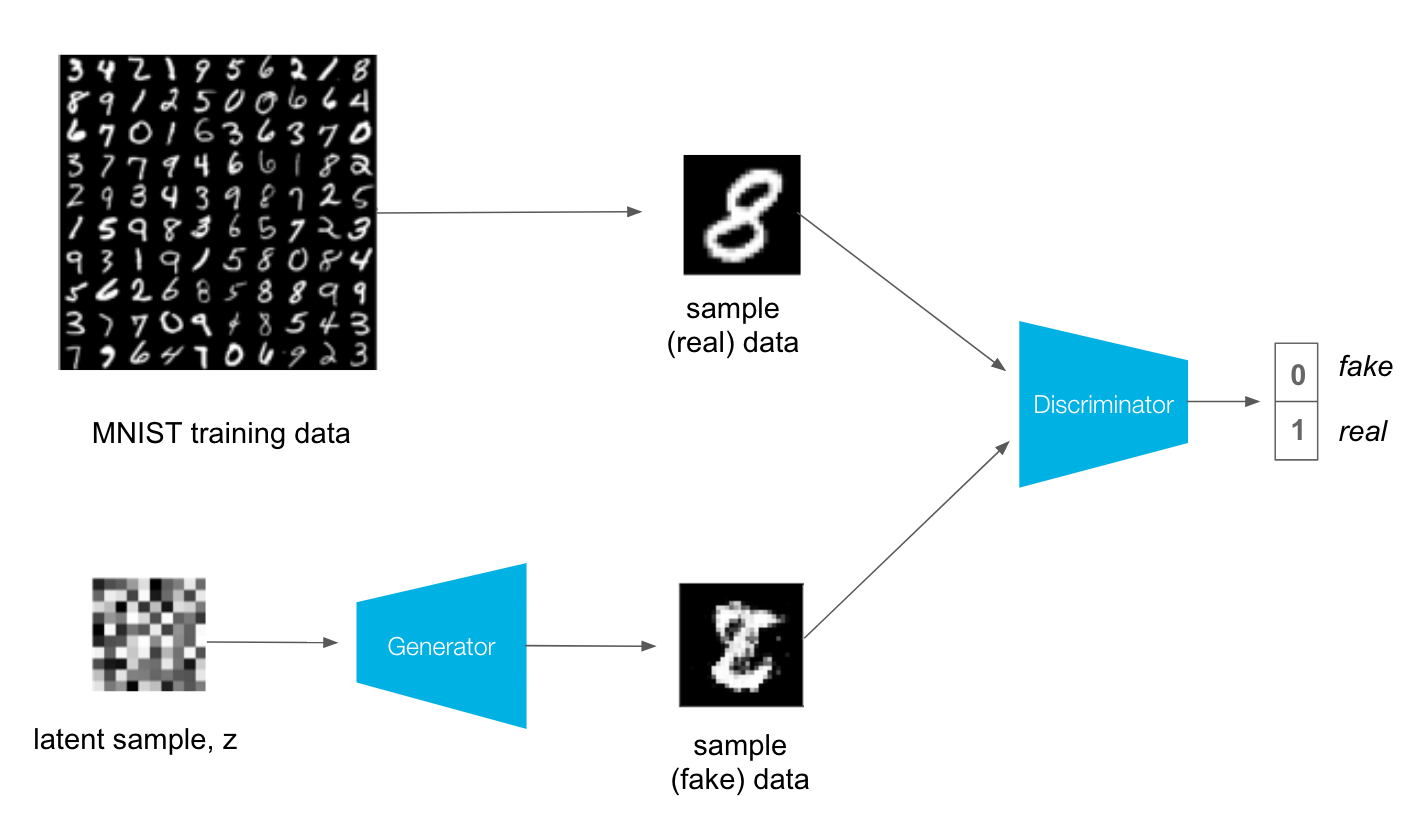
</div>

GANs are neural networks designed to generate synthetic data resembling known input data. From creating realistic images of faces to musics, GANs exhibit a remarkable ability to capture higher-order semantic logic.

The discriminator acts as a classifier, distinguishing between real dataset images and artificially generated ones. It is essentially a binary classifier, structured as a standard ANN.

On the other hand, the generator processes random input values, converting them into images using an ANN.

Throughout numerous training cycles, both the discriminator and generator adjust their weights and biases via backpropagation. The discriminator improves its ability to differentiate between authentic handwritten digits and synthetic ones produced by the generator. Simultaneously, the generator refines its output by learning from the discriminator's feedback, aiming to create images indistinguishable from real ones.

Building a GAN to generate simple images is straightforward. In this tutorial, we will train a GAN using images of MNIST handwritten digits. Through this process, the neural network will learn to generate new digits, effectively learning how to write.

![SegmentLocal](https://files.realpython.com/media/fig_gan_mnist.5d8784a85944.gif "segment")

In [ ]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

### MNIST Handwritten Digit Dataset

The MNIST dataset, short for Modified National Institute of Standards and Technology dataset, comprises 70,000 grayscale images. Each image is a small square of 28x28 pixels depicting handwritten single digits ranging from 0 to 9.

The goal with this dataset is to classify these handwritten digits into one of 10 classes, representing the integer values from 0 to 9.

Keras facilitates access to the MNIST dataset through the mnist.load_dataset() function. This function returns two tuples: one containing input and output elements for the standard training dataset, and another for the standard test dataset.

In [17]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


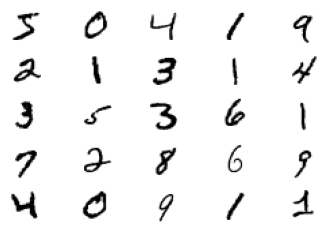

In [8]:
from matplotlib import pyplot
# plot images from the training dataset
for i in range(25):
 # define subplot
 pyplot.subplot(5, 5, 1 + i)
 # turn off axis
 pyplot.axis('off')
 # plot raw pixel data
 pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [ ]:
# load and prepare mnist training images 
def load_real_samples():
    # load mnist dataset (28,28)
    (trainX, _), (_, _) = load_data()
    # add channels dimension (28,28,1)
    X = expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # normaize from [0,255] to [0,1]
    X = X / 255.0
    return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

### Discriminator Model

Our first task is to create a model that can distinguish between real and fake images. This is essentially a binary classification problem: given an image, the model should predict whether it is a real image from our dataset or a generated one.

Here are the specifics of our discriminator model:

    Input: A grayscale image with dimensions 28x28 pixels.
    Output: Binary classification indicating the likelihood that the input image is real or fake. 
    
The discriminator architecture includes two convolutional layers, each with 64 filters, a kernel size of 3, and a stride of 2. The output layer consists of a single node with a sigmoid activation function, which is suitable for binary classification tasks like the one here.

To train the discriminator effectively, we will employ certain techniques:

    LeakyReLU activation instead of ReLU for better gradient flow.
    Dropout to prevent overfitting.
    Adam optimizer with a learning rate of 0.0002 and momentum of 0.5 for efficient gradient descent.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 3136)             

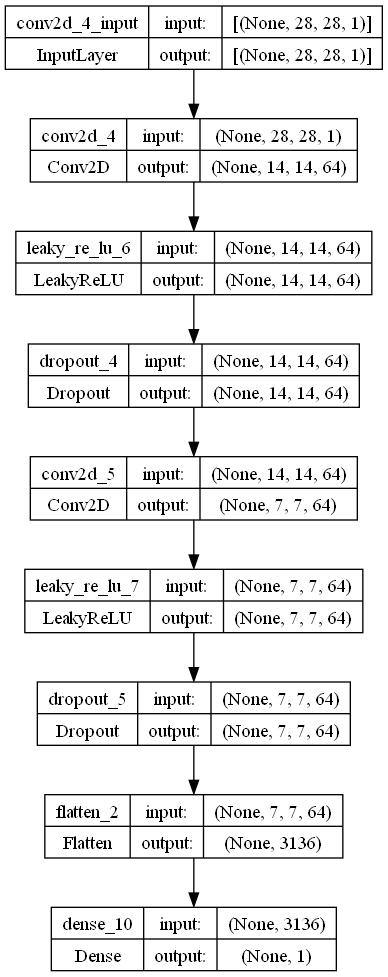

In [11]:
# example of defining the discriminator model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

### Generator network

The generator's role is to generate new, realistic yet synthetic images of handwritten digits. It achieves this by taking a point from the latent space as input and producing a square grayscale image as output.

The latent space represents an abstract vector space filled with Gaussian-distributed values, typically around 100 dimensions. Initially devoid of meaning, this space gains significance during training. By feeding random points from this space to the generator, it learns to map these points to meaningful representations, eventually transforming them into convincing MNIST images.

Key Details:
- Inputs: A point in the latent space, like a 100-dimensional vector of Gaussian random numbers.
- Outputs: A 2D grayscale image measuring 28x28 pixels, with pixel values ranging from 0 to 1.

While a 100-dimensional vector is commonly used, other dimensions like 10, 50, or 500 can be just as effective.

Creating the generator involves converting a latent vector of 100 dimensions into a 2D array with 28x28 or 784 values, representing the image.

Here's an overview of how we achieve this transformation:
    1. We start with a Dense layer as the first hidden layer, capable of representing a low-resolution version of the output image.
    2. These activations are reshaped into a set of feature maps (e.g., 128 different 7x7 maps).
    3. Upsampling techniques, specifically Conv2DTranspose layers, are used to increase the resolution of the image progressively. This avoids a checkerboard pattern that can occur during upsampling.
    4. We incorporate LeakyReLU activation functions throughout the model for enhanced gradient flow during training.

The output layer is a Conv2D layer designed to create a single feature map at 28x28 pixels, followed by a sigmoid activation to ensure output values fall within the desired range (0 to 1).


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 6272)              633472    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

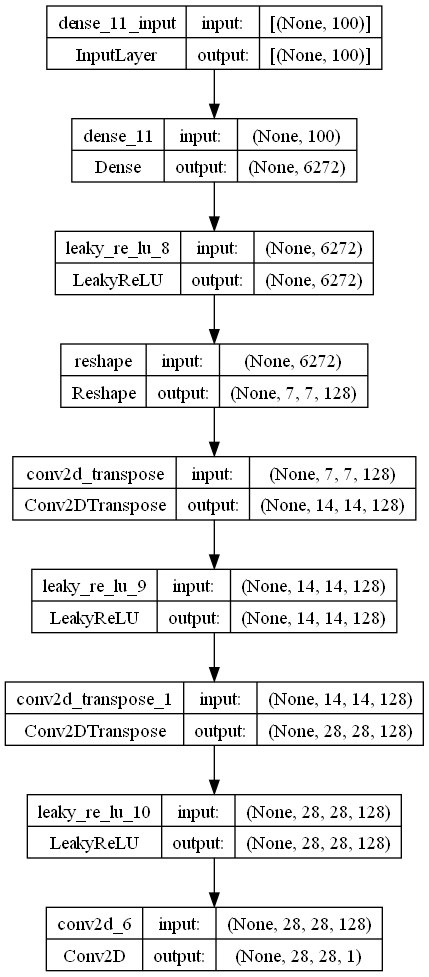

In [12]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

### Preparing Generator for Training

To train the generator, we rely on feedback from the discriminator.

Here's how it works:
    The generator creates fake images based on random points it receives.
    The discriminator then evaluates these fake images, determining how convincing they are.
    If the discriminator can easily spot the fakes, the generator adjusts its approach to create more realistic images. If the discriminator struggles, the generator does not change as much.

We set up a combined model, called a GAN model, that includes both the generator and discriminator. This setup allows the generator to improve based on how well the discriminator detects fakes.

The trick is that when training within this GAN setup, we make the discriminator focus only on real and fake distinctions, without worrying about its performance on real data.

By doing this, the generator gets better at fooling the discriminator, creating more realistic fake images as it learns.

This whole process, including freezing certain parts of the model during training, ensures a smooth and effective training experience for the generator, leading to better-generated images over time.

In [13]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

### Generate New Points in the Latent Space

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input



### Generate New Fake Images

We can use the generated points as input to the generator model to generate new samples

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

### Train and Evaluate the GAN Model
We now have everything we can train and evaluate the developed GAN on the MNIST handwritten digit dataset.

In [21]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [22]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)


In [23]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # create training set for the discriminator
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [24]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

4/4 [==============================] - 0s 45ms/step
>1, 1/234, d=0.683, g=0.784
4/4 [==============================] - 0s 4ms/step
>1, 2/234, d=0.675, g=0.804
4/4 [==============================] - 0s 4ms/step
>1, 3/234, d=0.663, g=0.825
4/4 [==============================] - 0s 4ms/step
>1, 4/234, d=0.659, g=0.847
4/4 [==============================] - 0s 4ms/step
>1, 5/234, d=0.649, g=0.865
4/4 [==============================] - 0s 4ms/step
>1, 6/234, d=0.640, g=0.878
4/4 [==============================] - 0s 4ms/step
>1, 7/234, d=0.643, g=0.894
4/4 [==============================] - 0s 4ms/step
>1, 8/234, d=0.632, g=0.892
4/4 [==============================] - 0s 4ms/step
>1, 9/234, d=0.636, g=0.891
4/4 [==============================] - 0s 4ms/step
>1, 10/234, d=0.642, g=0.873
4/4 [==============================] - 0s 3ms/step
>1, 11/234, d=0.645, g=0.846
4/4 [==============================] - 0s 4ms/step
>1, 12/234, d=0.651, g=0.812
4/4 [==============================] - 0s 4ms/st

4/4 [==============================] - 0s 4ms/step
>1, 204/234, d=1.055, g=0.759
4/4 [==============================] - 0s 4ms/step
>1, 205/234, d=1.020, g=0.730
4/4 [==============================] - 0s 4ms/step
>1, 206/234, d=1.011, g=0.697
4/4 [==============================] - 0s 4ms/step
>1, 207/234, d=0.988, g=0.711
4/4 [==============================] - 0s 4ms/step
>1, 208/234, d=0.951, g=0.685
4/4 [==============================] - 0s 4ms/step
>1, 209/234, d=0.939, g=0.726
4/4 [==============================] - 0s 4ms/step
>1, 210/234, d=0.872, g=0.723
4/4 [==============================] - 0s 4ms/step
>1, 211/234, d=0.856, g=0.745
4/4 [==============================] - 0s 4ms/step
>1, 212/234, d=0.870, g=0.733
4/4 [==============================] - 0s 4ms/step
>1, 213/234, d=0.796, g=0.789
4/4 [==============================] - 0s 4ms/step
>1, 214/234, d=0.811, g=0.791
4/4 [==============================] - 0s 4ms/step
>1, 215/234, d=0.743, g=0.824
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>2, 173/234, d=0.705, g=0.747
4/4 [==============================] - 0s 4ms/step
>2, 174/234, d=0.733, g=0.748
4/4 [==============================] - 0s 4ms/step
>2, 175/234, d=0.725, g=0.745
4/4 [==============================] - 0s 4ms/step
>2, 176/234, d=0.710, g=0.726
4/4 [==============================] - 0s 4ms/step
>2, 177/234, d=0.736, g=0.748
4/4 [==============================] - 0s 4ms/step
>2, 178/234, d=0.712, g=0.726
4/4 [==============================] - 0s 4ms/step
>2, 179/234, d=0.697, g=0.723
4/4 [==============================] - 0s 4ms/step
>2, 180/234, d=0.704, g=0.767
4/4 [==============================] - 0s 4ms/step
>2, 181/234, d=0.692, g=0.741
4/4 [==============================] - 0s 4ms/step
>2, 182/234, d=0.691, g=0.733
4/4 [==============================] - 0s 4ms/step
>2, 183/234, d=0.696, g=0.746
4/4 [==============================] - 0s 4ms/step
>2, 184/234, d=0.718, g=0.750
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>3, 41/234, d=0.711, g=0.731
4/4 [==============================] - 0s 4ms/step
>3, 42/234, d=0.706, g=0.719
4/4 [==============================] - 0s 4ms/step
>3, 43/234, d=0.720, g=0.704
4/4 [==============================] - 0s 4ms/step
>3, 44/234, d=0.718, g=0.726
4/4 [==============================] - 0s 4ms/step
>3, 45/234, d=0.707, g=0.727
4/4 [==============================] - 0s 4ms/step
>3, 46/234, d=0.722, g=0.715
4/4 [==============================] - 0s 3ms/step
>3, 47/234, d=0.703, g=0.726
4/4 [==============================] - 0s 4ms/step
>3, 48/234, d=0.709, g=0.699
4/4 [==============================] - 0s 4ms/step
>3, 49/234, d=0.702, g=0.721
4/4 [==============================] - 0s 4ms/step
>3, 50/234, d=0.716, g=0.726
4/4 [==============================] - 0s 4ms/step
>3, 51/234, d=0.706, g=0.731
4/4 [==============================] - 0s 4ms/step
>3, 52/234, d=0.699, g=0.700
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step
>3, 143/234, d=0.686, g=0.733
4/4 [==============================] - 0s 4ms/step
>3, 144/234, d=0.656, g=0.750
4/4 [==============================] - 0s 4ms/step
>3, 145/234, d=0.657, g=0.742
4/4 [==============================] - 0s 4ms/step
>3, 146/234, d=0.665, g=0.752
4/4 [==============================] - 0s 4ms/step
>3, 147/234, d=0.657, g=0.729
4/4 [==============================] - 0s 4ms/step
>3, 148/234, d=0.674, g=0.745
4/4 [==============================] - 0s 3ms/step
>3, 149/234, d=0.664, g=0.732
4/4 [==============================] - 0s 4ms/step
>3, 150/234, d=0.690, g=0.739
4/4 [==============================] - 0s 4ms/step
>3, 151/234, d=0.679, g=0.728
4/4 [==============================] - 0s 4ms/step
>3, 152/234, d=0.693, g=0.727
4/4 [==============================] - 0s 4ms/step
>3, 153/234, d=0.691, g=0.737
4/4 [==============================] - 0s 4ms/step
>3, 154/234, d=0.691, g=0.707
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>4, 112/234, d=0.687, g=0.726
4/4 [==============================] - 0s 4ms/step
>4, 113/234, d=0.675, g=0.723
4/4 [==============================] - 0s 4ms/step
>4, 114/234, d=0.672, g=0.724
4/4 [==============================] - 0s 4ms/step
>4, 115/234, d=0.698, g=0.721
4/4 [==============================] - 0s 4ms/step
>4, 116/234, d=0.687, g=0.710
4/4 [==============================] - 0s 4ms/step
>4, 117/234, d=0.684, g=0.723
4/4 [==============================] - 0s 4ms/step
>4, 118/234, d=0.692, g=0.721
4/4 [==============================] - 0s 4ms/step
>4, 119/234, d=0.676, g=0.724
4/4 [==============================] - 0s 4ms/step
>4, 120/234, d=0.674, g=0.718
4/4 [==============================] - 0s 4ms/step
>4, 121/234, d=0.676, g=0.719
4/4 [==============================] - 0s 4ms/step
>4, 122/234, d=0.672, g=0.729
4/4 [==============================] - 0s 4ms/step
>4, 123/234, d=0.678, g=0.730
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>5, 81/234, d=0.693, g=0.703
4/4 [==============================] - 0s 4ms/step
>5, 82/234, d=0.691, g=0.699
4/4 [==============================] - 0s 4ms/step
>5, 83/234, d=0.688, g=0.704
4/4 [==============================] - 0s 4ms/step
>5, 84/234, d=0.701, g=0.687
4/4 [==============================] - 0s 4ms/step
>5, 85/234, d=0.681, g=0.694
4/4 [==============================] - 0s 4ms/step
>5, 86/234, d=0.681, g=0.689
4/4 [==============================] - 0s 4ms/step
>5, 87/234, d=0.687, g=0.707
4/4 [==============================] - 0s 4ms/step
>5, 88/234, d=0.680, g=0.720
4/4 [==============================] - 0s 4ms/step
>5, 89/234, d=0.695, g=0.709
4/4 [==============================] - 0s 4ms/step
>5, 90/234, d=0.702, g=0.697
4/4 [==============================] - 0s 4ms/step
>5, 91/234, d=0.696, g=0.702
4/4 [==============================] - 0s 4ms/step
>5, 92/234, d=0.688, g=0.709
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step
>6, 50/234, d=0.694, g=0.706
4/4 [==============================] - 0s 4ms/step
>6, 51/234, d=0.699, g=0.704
4/4 [==============================] - 0s 4ms/step
>6, 52/234, d=0.693, g=0.693
4/4 [==============================] - 0s 4ms/step
>6, 53/234, d=0.691, g=0.711
4/4 [==============================] - 0s 4ms/step
>6, 54/234, d=0.692, g=0.694
4/4 [==============================] - 0s 3ms/step
>6, 55/234, d=0.694, g=0.704
4/4 [==============================] - 0s 4ms/step
>6, 56/234, d=0.697, g=0.705
4/4 [==============================] - 0s 4ms/step
>6, 57/234, d=0.694, g=0.702
4/4 [==============================] - 0s 4ms/step
>6, 58/234, d=0.692, g=0.688
4/4 [==============================] - 0s 4ms/step
>6, 59/234, d=0.691, g=0.681
4/4 [==============================] - 0s 4ms/step
>6, 60/234, d=0.693, g=0.676
4/4 [==============================] - 0s 4ms/step
>6, 61/234, d=0.685, g=0.697
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step
>6, 152/234, d=0.694, g=0.715
4/4 [==============================] - 0s 4ms/step
>6, 153/234, d=0.681, g=0.725
4/4 [==============================] - 0s 4ms/step
>6, 154/234, d=0.700, g=0.711
4/4 [==============================] - 0s 4ms/step
>6, 155/234, d=0.683, g=0.700
4/4 [==============================] - 0s 4ms/step
>6, 156/234, d=0.691, g=0.710
4/4 [==============================] - 0s 4ms/step
>6, 157/234, d=0.698, g=0.709
4/4 [==============================] - 0s 4ms/step
>6, 158/234, d=0.689, g=0.705
4/4 [==============================] - 0s 3ms/step
>6, 159/234, d=0.708, g=0.688
4/4 [==============================] - 0s 4ms/step
>6, 160/234, d=0.698, g=0.694
4/4 [==============================] - 0s 4ms/step
>6, 161/234, d=0.696, g=0.700
4/4 [==============================] - 0s 4ms/step
>6, 162/234, d=0.700, g=0.680
4/4 [==============================] - 0s 4ms/step
>6, 163/234, d=0.695, g=0.679
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>7, 121/234, d=0.682, g=0.784
4/4 [==============================] - 0s 4ms/step
>7, 122/234, d=0.676, g=0.768
4/4 [==============================] - 0s 4ms/step
>7, 123/234, d=0.674, g=0.748
4/4 [==============================] - 0s 4ms/step
>7, 124/234, d=0.673, g=0.728
4/4 [==============================] - 0s 4ms/step
>7, 125/234, d=0.685, g=0.716
4/4 [==============================] - 0s 4ms/step
>7, 126/234, d=0.679, g=0.688
4/4 [==============================] - 0s 4ms/step
>7, 127/234, d=0.673, g=0.678
4/4 [==============================] - 0s 4ms/step
>7, 128/234, d=0.680, g=0.657
4/4 [==============================] - 0s 4ms/step
>7, 129/234, d=0.685, g=0.656
4/4 [==============================] - 0s 4ms/step
>7, 130/234, d=0.682, g=0.665
4/4 [==============================] - 0s 4ms/step
>7, 131/234, d=0.689, g=0.673
4/4 [==============================] - 0s 4ms/step
>7, 132/234, d=0.691, g=0.696
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>8, 90/234, d=0.691, g=0.700
4/4 [==============================] - 0s 3ms/step
>8, 91/234, d=0.679, g=0.695
4/4 [==============================] - 0s 4ms/step
>8, 92/234, d=0.682, g=0.706
4/4 [==============================] - 0s 4ms/step
>8, 93/234, d=0.684, g=0.701
4/4 [==============================] - 0s 4ms/step
>8, 94/234, d=0.694, g=0.709
4/4 [==============================] - 0s 4ms/step
>8, 95/234, d=0.688, g=0.723
4/4 [==============================] - 0s 4ms/step
>8, 96/234, d=0.692, g=0.719
4/4 [==============================] - 0s 4ms/step
>8, 97/234, d=0.698, g=0.712
4/4 [==============================] - 0s 4ms/step
>8, 98/234, d=0.686, g=0.714
4/4 [==============================] - 0s 4ms/step
>8, 99/234, d=0.700, g=0.713
4/4 [==============================] - 0s 4ms/step
>8, 100/234, d=0.695, g=0.709
4/4 [==============================] - 0s 4ms/step
>8, 101/234, d=0.701, g=0.702
4/4 [==============================] -

4/4 [==============================] - 0s 4ms/step
>9, 59/234, d=0.682, g=0.725
4/4 [==============================] - 0s 4ms/step
>9, 60/234, d=0.680, g=0.726
4/4 [==============================] - 0s 4ms/step
>9, 61/234, d=0.686, g=0.709
4/4 [==============================] - 0s 4ms/step
>9, 62/234, d=0.682, g=0.713
4/4 [==============================] - 0s 4ms/step
>9, 63/234, d=0.680, g=0.695
4/4 [==============================] - 0s 4ms/step
>9, 64/234, d=0.678, g=0.689
4/4 [==============================] - 0s 4ms/step
>9, 65/234, d=0.685, g=0.688
4/4 [==============================] - 0s 4ms/step
>9, 66/234, d=0.677, g=0.689
4/4 [==============================] - 0s 4ms/step
>9, 67/234, d=0.684, g=0.695
4/4 [==============================] - 0s 4ms/step
>9, 68/234, d=0.687, g=0.702
4/4 [==============================] - 0s 4ms/step
>9, 69/234, d=0.686, g=0.721
4/4 [==============================] - 0s 4ms/step
>9, 70/234, d=0.687, g=0.721
4/4 [==============================] - 0

4/4 [==============================] - 0s 4ms/step
>9, 161/234, d=0.686, g=0.692
4/4 [==============================] - 0s 4ms/step
>9, 162/234, d=0.692, g=0.690
4/4 [==============================] - 0s 4ms/step
>9, 163/234, d=0.693, g=0.704
4/4 [==============================] - 0s 4ms/step
>9, 164/234, d=0.694, g=0.707
4/4 [==============================] - 0s 4ms/step
>9, 165/234, d=0.690, g=0.715
4/4 [==============================] - 0s 4ms/step
>9, 166/234, d=0.701, g=0.702
4/4 [==============================] - 0s 4ms/step
>9, 167/234, d=0.698, g=0.689
4/4 [==============================] - 0s 4ms/step
>9, 168/234, d=0.705, g=0.670
4/4 [==============================] - 0s 4ms/step
>9, 169/234, d=0.701, g=0.672
4/4 [==============================] - 0s 4ms/step
>9, 170/234, d=0.699, g=0.667
4/4 [==============================] - 0s 4ms/step
>9, 171/234, d=0.703, g=0.668
4/4 [==============================] - 0s 4ms/step
>9, 172/234, d=0.691, g=0.679
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>10, 129/234, d=0.674, g=0.697
4/4 [==============================] - 0s 4ms/step
>10, 130/234, d=0.670, g=0.693
4/4 [==============================] - 0s 4ms/step
>10, 131/234, d=0.677, g=0.704
4/4 [==============================] - 0s 4ms/step
>10, 132/234, d=0.682, g=0.708
4/4 [==============================] - 0s 4ms/step
>10, 133/234, d=0.685, g=0.717
4/4 [==============================] - 0s 4ms/step
>10, 134/234, d=0.688, g=0.713
4/4 [==============================] - 0s 4ms/step
>10, 135/234, d=0.682, g=0.724
4/4 [==============================] - 0s 4ms/step
>10, 136/234, d=0.690, g=0.711
4/4 [==============================] - 0s 4ms/step
>10, 137/234, d=0.699, g=0.710
4/4 [==============================] - 0s 4ms/step
>10, 138/234, d=0.691, g=0.696
4/4 [==============================] - 0s 4ms/step
>10, 139/234, d=0.686, g=0.682
4/4 [==============================] - 0s 4ms/step
>10, 140/234, d=0.688, g=0.684
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>10, 229/234, d=0.675, g=0.734
4/4 [==============================] - 0s 4ms/step
>10, 230/234, d=0.675, g=0.735
4/4 [==============================] - 0s 4ms/step
>10, 231/234, d=0.669, g=0.718
4/4 [==============================] - 0s 4ms/step
>10, 232/234, d=0.670, g=0.704
4/4 [==============================] - 0s 4ms/step
>10, 233/234, d=0.667, g=0.709
4/4 [==============================] - 0s 4ms/step
>10, 234/234, d=0.663, g=0.708
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 93%, fake: 44%
4/4 [==============================] - 0s 10ms/step
>11, 1/234, d=0.655, g=0.718
4/4 [==============================] - 0s 9ms/step
>11, 2/234, d=0.667, g=0.722
4/4 [==============================] - 0s 4ms/step
>11, 3/234, d=0.668, g=0.722
4/4 [==============================] - 0s 4ms/step
>11, 4/234, d=0.675, g=0.737
4/4 [==============================] - 0s 4ms/step
>11, 5/234, d=0.683, g=0.733
4/4 [====================

4/4 [==============================] - 0s 4ms/step
>11, 193/234, d=0.694, g=0.672
4/4 [==============================] - 0s 4ms/step
>11, 194/234, d=0.686, g=0.674
4/4 [==============================] - 0s 4ms/step
>11, 195/234, d=0.687, g=0.679
4/4 [==============================] - 0s 4ms/step
>11, 196/234, d=0.698, g=0.703
4/4 [==============================] - 0s 4ms/step
>11, 197/234, d=0.691, g=0.730
4/4 [==============================] - 0s 4ms/step
>11, 198/234, d=0.688, g=0.765
4/4 [==============================] - 0s 4ms/step
>11, 199/234, d=0.678, g=0.792
4/4 [==============================] - 0s 4ms/step
>11, 200/234, d=0.681, g=0.789
4/4 [==============================] - 0s 4ms/step
>11, 201/234, d=0.689, g=0.761
4/4 [==============================] - 0s 4ms/step
>11, 202/234, d=0.692, g=0.717
4/4 [==============================] - 0s 4ms/step
>11, 203/234, d=0.689, g=0.680
4/4 [==============================] - 0s 4ms/step
>11, 204/234, d=0.696, g=0.669
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>12, 60/234, d=0.690, g=0.689
4/4 [==============================] - 0s 4ms/step
>12, 61/234, d=0.680, g=0.701
4/4 [==============================] - 0s 4ms/step
>12, 62/234, d=0.680, g=0.704
4/4 [==============================] - 0s 4ms/step
>12, 63/234, d=0.678, g=0.709
4/4 [==============================] - 0s 4ms/step
>12, 64/234, d=0.689, g=0.716
4/4 [==============================] - 0s 4ms/step
>12, 65/234, d=0.677, g=0.716
4/4 [==============================] - 0s 4ms/step
>12, 66/234, d=0.681, g=0.717
4/4 [==============================] - 0s 4ms/step
>12, 67/234, d=0.684, g=0.738
4/4 [==============================] - 0s 4ms/step
>12, 68/234, d=0.686, g=0.735
4/4 [==============================] - 0s 4ms/step
>12, 69/234, d=0.689, g=0.746
4/4 [==============================] - 0s 4ms/step
>12, 70/234, d=0.681, g=0.753
4/4 [==============================] - 0s 4ms/step
>12, 71/234, d=0.686, g=0.730
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>13, 26/234, d=0.685, g=0.722
4/4 [==============================] - 0s 4ms/step
>13, 27/234, d=0.693, g=0.712
4/4 [==============================] - 0s 4ms/step
>13, 28/234, d=0.684, g=0.714
4/4 [==============================] - 0s 4ms/step
>13, 29/234, d=0.688, g=0.698
4/4 [==============================] - 0s 4ms/step
>13, 30/234, d=0.679, g=0.685
4/4 [==============================] - 0s 4ms/step
>13, 31/234, d=0.688, g=0.676
4/4 [==============================] - 0s 4ms/step
>13, 32/234, d=0.679, g=0.681
4/4 [==============================] - 0s 4ms/step
>13, 33/234, d=0.690, g=0.681
4/4 [==============================] - 0s 4ms/step
>13, 34/234, d=0.682, g=0.694
4/4 [==============================] - 0s 4ms/step
>13, 35/234, d=0.677, g=0.705
4/4 [==============================] - 0s 4ms/step
>13, 36/234, d=0.683, g=0.723
4/4 [==============================] - 0s 4ms/step
>13, 37/234, d=0.685, g=0.749
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>13, 127/234, d=0.694, g=0.708
4/4 [==============================] - 0s 4ms/step
>13, 128/234, d=0.687, g=0.709
4/4 [==============================] - 0s 4ms/step
>13, 129/234, d=0.684, g=0.708
4/4 [==============================] - 0s 4ms/step
>13, 130/234, d=0.682, g=0.715
4/4 [==============================] - 0s 4ms/step
>13, 131/234, d=0.676, g=0.732
4/4 [==============================] - 0s 4ms/step
>13, 132/234, d=0.680, g=0.732
4/4 [==============================] - 0s 4ms/step
>13, 133/234, d=0.686, g=0.721
4/4 [==============================] - 0s 4ms/step
>13, 134/234, d=0.682, g=0.708
4/4 [==============================] - 0s 4ms/step
>13, 135/234, d=0.681, g=0.710
4/4 [==============================] - 0s 4ms/step
>13, 136/234, d=0.676, g=0.705
4/4 [==============================] - 0s 4ms/step
>13, 137/234, d=0.675, g=0.687
4/4 [==============================] - 0s 4ms/step
>13, 138/234, d=0.679, g=0.686
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>13, 227/234, d=0.701, g=0.707
4/4 [==============================] - 0s 4ms/step
>13, 228/234, d=0.693, g=0.695
4/4 [==============================] - 0s 4ms/step
>13, 229/234, d=0.682, g=0.692
4/4 [==============================] - 0s 4ms/step
>13, 230/234, d=0.686, g=0.691
4/4 [==============================] - 0s 4ms/step
>13, 231/234, d=0.685, g=0.689
4/4 [==============================] - 0s 4ms/step
>13, 232/234, d=0.688, g=0.693
4/4 [==============================] - 0s 4ms/step
>13, 233/234, d=0.688, g=0.709
4/4 [==============================] - 0s 4ms/step
>13, 234/234, d=0.679, g=0.712
4/4 [==============================] - 0s 4ms/step
>14, 1/234, d=0.679, g=0.721
4/4 [==============================] - 0s 4ms/step
>14, 2/234, d=0.690, g=0.727
4/4 [==============================] - 0s 4ms/step
>14, 3/234, d=0.683, g=0.729
4/4 [==============================] - 0s 4ms/step
>14, 4/234, d=0.688, g=0.723
4/4 [===================

4/4 [==============================] - 0s 4ms/step
>14, 194/234, d=0.683, g=0.733
4/4 [==============================] - 0s 4ms/step
>14, 195/234, d=0.679, g=0.724
4/4 [==============================] - 0s 4ms/step
>14, 196/234, d=0.684, g=0.723
4/4 [==============================] - 0s 4ms/step
>14, 197/234, d=0.696, g=0.698
4/4 [==============================] - 0s 5ms/step
>14, 198/234, d=0.685, g=0.684
4/4 [==============================] - 0s 4ms/step
>14, 199/234, d=0.682, g=0.690
4/4 [==============================] - 0s 4ms/step
>14, 200/234, d=0.682, g=0.682
4/4 [==============================] - 0s 4ms/step
>14, 201/234, d=0.692, g=0.706
4/4 [==============================] - 0s 4ms/step
>14, 202/234, d=0.686, g=0.709
4/4 [==============================] - 0s 4ms/step
>14, 203/234, d=0.691, g=0.709
4/4 [==============================] - 0s 4ms/step
>14, 204/234, d=0.691, g=0.707
4/4 [==============================] - 0s 4ms/step
>14, 205/234, d=0.690, g=0.705
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>15, 61/234, d=0.682, g=0.658
4/4 [==============================] - 0s 4ms/step
>15, 62/234, d=0.687, g=0.664
4/4 [==============================] - 0s 4ms/step
>15, 63/234, d=0.690, g=0.678
4/4 [==============================] - 0s 4ms/step
>15, 64/234, d=0.687, g=0.710
4/4 [==============================] - 0s 4ms/step
>15, 65/234, d=0.687, g=0.747
4/4 [==============================] - 0s 4ms/step
>15, 66/234, d=0.690, g=0.755
4/4 [==============================] - 0s 4ms/step
>15, 67/234, d=0.686, g=0.772
4/4 [==============================] - 0s 4ms/step
>15, 68/234, d=0.689, g=0.750
4/4 [==============================] - 0s 4ms/step
>15, 69/234, d=0.689, g=0.725
4/4 [==============================] - 0s 4ms/step
>15, 70/234, d=0.688, g=0.689
4/4 [==============================] - 0s 4ms/step
>15, 71/234, d=0.693, g=0.676
4/4 [==============================] - 0s 4ms/step
>15, 72/234, d=0.681, g=0.664
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>16, 27/234, d=0.690, g=0.677
4/4 [==============================] - 0s 4ms/step
>16, 28/234, d=0.683, g=0.677
4/4 [==============================] - 0s 4ms/step
>16, 29/234, d=0.690, g=0.698
4/4 [==============================] - 0s 4ms/step
>16, 30/234, d=0.690, g=0.730
4/4 [==============================] - 0s 4ms/step
>16, 31/234, d=0.683, g=0.744
4/4 [==============================] - 0s 4ms/step
>16, 32/234, d=0.686, g=0.756
4/4 [==============================] - 0s 4ms/step
>16, 33/234, d=0.689, g=0.735
4/4 [==============================] - 0s 4ms/step
>16, 34/234, d=0.687, g=0.704
4/4 [==============================] - 0s 4ms/step
>16, 35/234, d=0.690, g=0.712
4/4 [==============================] - 0s 4ms/step
>16, 36/234, d=0.688, g=0.694
4/4 [==============================] - 0s 4ms/step
>16, 37/234, d=0.684, g=0.697
4/4 [==============================] - 0s 4ms/step
>16, 38/234, d=0.691, g=0.693
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>16, 128/234, d=0.682, g=0.654
4/4 [==============================] - 0s 4ms/step
>16, 129/234, d=0.683, g=0.675
4/4 [==============================] - 0s 4ms/step
>16, 130/234, d=0.685, g=0.726
4/4 [==============================] - 0s 4ms/step
>16, 131/234, d=0.683, g=0.772
4/4 [==============================] - 0s 4ms/step
>16, 132/234, d=0.687, g=0.784
4/4 [==============================] - 0s 4ms/step
>16, 133/234, d=0.687, g=0.773
4/4 [==============================] - 0s 4ms/step
>16, 134/234, d=0.686, g=0.725
4/4 [==============================] - 0s 4ms/step
>16, 135/234, d=0.684, g=0.688
4/4 [==============================] - 0s 4ms/step
>16, 136/234, d=0.685, g=0.676
4/4 [==============================] - 0s 4ms/step
>16, 137/234, d=0.684, g=0.657
4/4 [==============================] - 0s 4ms/step
>16, 138/234, d=0.682, g=0.654
4/4 [==============================] - 0s 4ms/step
>16, 139/234, d=0.681, g=0.674
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>16, 228/234, d=0.694, g=0.745
4/4 [==============================] - 0s 4ms/step
>16, 229/234, d=0.685, g=0.755
4/4 [==============================] - 0s 4ms/step
>16, 230/234, d=0.685, g=0.726
4/4 [==============================] - 0s 4ms/step
>16, 231/234, d=0.695, g=0.703
4/4 [==============================] - 0s 4ms/step
>16, 232/234, d=0.691, g=0.678
4/4 [==============================] - 0s 4ms/step
>16, 233/234, d=0.692, g=0.662
4/4 [==============================] - 0s 4ms/step
>16, 234/234, d=0.686, g=0.670
4/4 [==============================] - 0s 4ms/step
>17, 1/234, d=0.684, g=0.690
4/4 [==============================] - 0s 4ms/step
>17, 2/234, d=0.686, g=0.713
4/4 [==============================] - 0s 4ms/step
>17, 3/234, d=0.689, g=0.737
4/4 [==============================] - 0s 4ms/step
>17, 4/234, d=0.687, g=0.741
4/4 [==============================] - 0s 4ms/step
>17, 5/234, d=0.685, g=0.732
4/4 [=====================

4/4 [==============================] - 0s 4ms/step
>17, 195/234, d=0.679, g=0.745
4/4 [==============================] - 0s 4ms/step
>17, 196/234, d=0.688, g=0.697
4/4 [==============================] - 0s 4ms/step
>17, 197/234, d=0.683, g=0.659
4/4 [==============================] - 0s 4ms/step
>17, 198/234, d=0.679, g=0.663
4/4 [==============================] - 0s 4ms/step
>17, 199/234, d=0.673, g=0.661
4/4 [==============================] - 0s 4ms/step
>17, 200/234, d=0.697, g=0.673
4/4 [==============================] - 0s 4ms/step
>17, 201/234, d=0.689, g=0.720
4/4 [==============================] - 0s 4ms/step
>17, 202/234, d=0.693, g=0.755
4/4 [==============================] - 0s 4ms/step
>17, 203/234, d=0.688, g=0.778
4/4 [==============================] - 0s 4ms/step
>17, 204/234, d=0.692, g=0.756
4/4 [==============================] - 0s 4ms/step
>17, 205/234, d=0.696, g=0.726
4/4 [==============================] - 0s 5ms/step
>17, 206/234, d=0.696, g=0.676
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>18, 62/234, d=0.685, g=0.748
4/4 [==============================] - 0s 4ms/step
>18, 63/234, d=0.680, g=0.747
4/4 [==============================] - 0s 4ms/step
>18, 64/234, d=0.691, g=0.745
4/4 [==============================] - 0s 4ms/step
>18, 65/234, d=0.679, g=0.720
4/4 [==============================] - 0s 4ms/step
>18, 66/234, d=0.692, g=0.699
4/4 [==============================] - 0s 4ms/step
>18, 67/234, d=0.682, g=0.685
4/4 [==============================] - 0s 4ms/step
>18, 68/234, d=0.687, g=0.682
4/4 [==============================] - 0s 4ms/step
>18, 69/234, d=0.681, g=0.679
4/4 [==============================] - 0s 4ms/step
>18, 70/234, d=0.688, g=0.687
4/4 [==============================] - 0s 4ms/step
>18, 71/234, d=0.683, g=0.721
4/4 [==============================] - 0s 4ms/step
>18, 72/234, d=0.687, g=0.731
4/4 [==============================] - 0s 4ms/step
>18, 73/234, d=0.691, g=0.760
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>19, 28/234, d=0.676, g=0.733
4/4 [==============================] - 0s 4ms/step
>19, 29/234, d=0.689, g=0.715
4/4 [==============================] - 0s 4ms/step
>19, 30/234, d=0.687, g=0.694
4/4 [==============================] - 0s 5ms/step
>19, 31/234, d=0.693, g=0.671
4/4 [==============================] - 0s 4ms/step
>19, 32/234, d=0.686, g=0.670
4/4 [==============================] - 0s 4ms/step
>19, 33/234, d=0.689, g=0.676
4/4 [==============================] - 0s 4ms/step
>19, 34/234, d=0.687, g=0.705
4/4 [==============================] - 0s 4ms/step
>19, 35/234, d=0.695, g=0.749
4/4 [==============================] - 0s 4ms/step
>19, 36/234, d=0.693, g=0.762
4/4 [==============================] - 0s 4ms/step
>19, 37/234, d=0.693, g=0.741
4/4 [==============================] - 0s 4ms/step
>19, 38/234, d=0.689, g=0.712
4/4 [==============================] - 0s 4ms/step
>19, 39/234, d=0.687, g=0.676
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>19, 129/234, d=0.695, g=0.697
4/4 [==============================] - 0s 4ms/step
>19, 130/234, d=0.678, g=0.663
4/4 [==============================] - 0s 4ms/step
>19, 131/234, d=0.692, g=0.649
4/4 [==============================] - 0s 4ms/step
>19, 132/234, d=0.693, g=0.661
4/4 [==============================] - 0s 4ms/step
>19, 133/234, d=0.695, g=0.686
4/4 [==============================] - 0s 4ms/step
>19, 134/234, d=0.692, g=0.726
4/4 [==============================] - 0s 4ms/step
>19, 135/234, d=0.693, g=0.743
4/4 [==============================] - 0s 4ms/step
>19, 136/234, d=0.691, g=0.732
4/4 [==============================] - 0s 4ms/step
>19, 137/234, d=0.684, g=0.737
4/4 [==============================] - 0s 4ms/step
>19, 138/234, d=0.694, g=0.720
4/4 [==============================] - 0s 4ms/step
>19, 139/234, d=0.693, g=0.714
4/4 [==============================] - 0s 4ms/step
>19, 140/234, d=0.688, g=0.702
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>19, 229/234, d=0.683, g=0.700
4/4 [==============================] - 0s 4ms/step
>19, 230/234, d=0.686, g=0.733
4/4 [==============================] - 0s 4ms/step
>19, 231/234, d=0.681, g=0.754
4/4 [==============================] - 0s 4ms/step
>19, 232/234, d=0.691, g=0.763
4/4 [==============================] - 0s 4ms/step
>19, 233/234, d=0.685, g=0.761
4/4 [==============================] - 0s 4ms/step
>19, 234/234, d=0.682, g=0.728
4/4 [==============================] - 0s 4ms/step
>20, 1/234, d=0.690, g=0.686
4/4 [==============================] - 0s 4ms/step
>20, 2/234, d=0.685, g=0.668
4/4 [==============================] - 0s 4ms/step
>20, 3/234, d=0.686, g=0.649
4/4 [==============================] - 0s 4ms/step
>20, 4/234, d=0.690, g=0.652
4/4 [==============================] - 0s 4ms/step
>20, 5/234, d=0.693, g=0.685
4/4 [==============================] - 0s 4ms/step
>20, 6/234, d=0.691, g=0.741
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>20, 196/234, d=0.689, g=0.645
4/4 [==============================] - 0s 4ms/step
>20, 197/234, d=0.687, g=0.636
4/4 [==============================] - 0s 4ms/step
>20, 198/234, d=0.680, g=0.637
4/4 [==============================] - 0s 4ms/step
>20, 199/234, d=0.685, g=0.681
4/4 [==============================] - 0s 4ms/step
>20, 200/234, d=0.695, g=0.731
4/4 [==============================] - 0s 4ms/step
>20, 201/234, d=0.694, g=0.781
4/4 [==============================] - 0s 4ms/step
>20, 202/234, d=0.688, g=0.792
4/4 [==============================] - 0s 4ms/step
>20, 203/234, d=0.681, g=0.760
4/4 [==============================] - 0s 4ms/step
>20, 204/234, d=0.692, g=0.720
4/4 [==============================] - 0s 4ms/step
>20, 205/234, d=0.686, g=0.693
4/4 [==============================] - 0s 4ms/step
>20, 206/234, d=0.690, g=0.665
4/4 [==============================] - 0s 4ms/step
>20, 207/234, d=0.690, g=0.671
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>21, 60/234, d=0.690, g=0.694
4/4 [==============================] - 0s 4ms/step
>21, 61/234, d=0.687, g=0.686
4/4 [==============================] - 0s 4ms/step
>21, 62/234, d=0.688, g=0.689
4/4 [==============================] - 0s 4ms/step
>21, 63/234, d=0.691, g=0.698
4/4 [==============================] - 0s 4ms/step
>21, 64/234, d=0.681, g=0.721
4/4 [==============================] - 0s 4ms/step
>21, 65/234, d=0.685, g=0.726
4/4 [==============================] - 0s 4ms/step
>21, 66/234, d=0.686, g=0.742
4/4 [==============================] - 0s 4ms/step
>21, 67/234, d=0.684, g=0.735
4/4 [==============================] - 0s 4ms/step
>21, 68/234, d=0.685, g=0.721
4/4 [==============================] - 0s 4ms/step
>21, 69/234, d=0.686, g=0.706
4/4 [==============================] - 0s 4ms/step
>21, 70/234, d=0.689, g=0.677
4/4 [==============================] - 0s 4ms/step
>21, 71/234, d=0.683, g=0.679
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>22, 26/234, d=0.695, g=0.667
4/4 [==============================] - 0s 4ms/step
>22, 27/234, d=0.680, g=0.663
4/4 [==============================] - 0s 4ms/step
>22, 28/234, d=0.690, g=0.681
4/4 [==============================] - 0s 4ms/step
>22, 29/234, d=0.693, g=0.713
4/4 [==============================] - 0s 4ms/step
>22, 30/234, d=0.685, g=0.741
4/4 [==============================] - 0s 4ms/step
>22, 31/234, d=0.698, g=0.757
4/4 [==============================] - 0s 4ms/step
>22, 32/234, d=0.683, g=0.768
4/4 [==============================] - 0s 4ms/step
>22, 33/234, d=0.686, g=0.731
4/4 [==============================] - 0s 4ms/step
>22, 34/234, d=0.689, g=0.680
4/4 [==============================] - 0s 4ms/step
>22, 35/234, d=0.680, g=0.652
4/4 [==============================] - 0s 4ms/step
>22, 36/234, d=0.679, g=0.645
4/4 [==============================] - 0s 4ms/step
>22, 37/234, d=0.693, g=0.664
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>22, 127/234, d=0.681, g=0.712
4/4 [==============================] - 0s 4ms/step
>22, 128/234, d=0.689, g=0.698
4/4 [==============================] - 0s 4ms/step
>22, 129/234, d=0.687, g=0.687
4/4 [==============================] - 0s 4ms/step
>22, 130/234, d=0.688, g=0.692
4/4 [==============================] - 0s 4ms/step
>22, 131/234, d=0.691, g=0.706
4/4 [==============================] - 0s 4ms/step
>22, 132/234, d=0.688, g=0.723
4/4 [==============================] - 0s 4ms/step
>22, 133/234, d=0.692, g=0.723
4/4 [==============================] - 0s 4ms/step
>22, 134/234, d=0.685, g=0.735
4/4 [==============================] - 0s 4ms/step
>22, 135/234, d=0.688, g=0.718
4/4 [==============================] - 0s 4ms/step
>22, 136/234, d=0.693, g=0.710
4/4 [==============================] - 0s 4ms/step
>22, 137/234, d=0.681, g=0.689
4/4 [==============================] - 0s 4ms/step
>22, 138/234, d=0.684, g=0.677
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>22, 227/234, d=0.687, g=0.659
4/4 [==============================] - 0s 4ms/step
>22, 228/234, d=0.687, g=0.643
4/4 [==============================] - 0s 4ms/step
>22, 229/234, d=0.686, g=0.637
4/4 [==============================] - 0s 4ms/step
>22, 230/234, d=0.687, g=0.646
4/4 [==============================] - 0s 4ms/step
>22, 231/234, d=0.694, g=0.687
4/4 [==============================] - 0s 4ms/step
>22, 232/234, d=0.695, g=0.760
4/4 [==============================] - 0s 4ms/step
>22, 233/234, d=0.684, g=0.826
4/4 [==============================] - 0s 4ms/step
>22, 234/234, d=0.685, g=0.837
4/4 [==============================] - 0s 4ms/step
>23, 1/234, d=0.689, g=0.771
4/4 [==============================] - 0s 4ms/step
>23, 2/234, d=0.692, g=0.705
4/4 [==============================] - 0s 4ms/step
>23, 3/234, d=0.685, g=0.657
4/4 [==============================] - 0s 4ms/step
>23, 4/234, d=0.684, g=0.644
4/4 [===================

4/4 [==============================] - 0s 4ms/step
>23, 194/234, d=0.684, g=0.724
4/4 [==============================] - 0s 4ms/step
>23, 195/234, d=0.690, g=0.743
4/4 [==============================] - 0s 4ms/step
>23, 196/234, d=0.689, g=0.736
4/4 [==============================] - 0s 4ms/step
>23, 197/234, d=0.687, g=0.719
4/4 [==============================] - 0s 4ms/step
>23, 198/234, d=0.687, g=0.717
4/4 [==============================] - 0s 4ms/step
>23, 199/234, d=0.688, g=0.690
4/4 [==============================] - 0s 4ms/step
>23, 200/234, d=0.687, g=0.676
4/4 [==============================] - 0s 4ms/step
>23, 201/234, d=0.683, g=0.676
4/4 [==============================] - 0s 4ms/step
>23, 202/234, d=0.696, g=0.671
4/4 [==============================] - 0s 4ms/step
>23, 203/234, d=0.694, g=0.701
4/4 [==============================] - 0s 4ms/step
>23, 204/234, d=0.695, g=0.728
4/4 [==============================] - 0s 4ms/step
>23, 205/234, d=0.688, g=0.759
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>24, 61/234, d=0.696, g=0.863
4/4 [==============================] - 0s 4ms/step
>24, 62/234, d=0.692, g=0.858
4/4 [==============================] - 0s 4ms/step
>24, 63/234, d=0.692, g=0.796
4/4 [==============================] - 0s 4ms/step
>24, 64/234, d=0.695, g=0.719
4/4 [==============================] - 0s 4ms/step
>24, 65/234, d=0.706, g=0.652
4/4 [==============================] - 0s 4ms/step
>24, 66/234, d=0.685, g=0.620
4/4 [==============================] - 0s 4ms/step
>24, 67/234, d=0.689, g=0.621
4/4 [==============================] - 0s 4ms/step
>24, 68/234, d=0.679, g=0.626
4/4 [==============================] - 0s 4ms/step
>24, 69/234, d=0.692, g=0.639
4/4 [==============================] - 0s 4ms/step
>24, 70/234, d=0.694, g=0.717
4/4 [==============================] - 0s 4ms/step
>24, 71/234, d=0.694, g=0.777
4/4 [==============================] - 0s 4ms/step
>24, 72/234, d=0.687, g=0.823
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>25, 27/234, d=0.686, g=0.737
4/4 [==============================] - 0s 4ms/step
>25, 28/234, d=0.683, g=0.716
4/4 [==============================] - 0s 4ms/step
>25, 29/234, d=0.691, g=0.688
4/4 [==============================] - 0s 4ms/step
>25, 30/234, d=0.683, g=0.669
4/4 [==============================] - 0s 4ms/step
>25, 31/234, d=0.688, g=0.667
4/4 [==============================] - 0s 4ms/step
>25, 32/234, d=0.687, g=0.667
4/4 [==============================] - 0s 4ms/step
>25, 33/234, d=0.680, g=0.694
4/4 [==============================] - 0s 4ms/step
>25, 34/234, d=0.687, g=0.729
4/4 [==============================] - 0s 4ms/step
>25, 35/234, d=0.688, g=0.765
4/4 [==============================] - 0s 4ms/step
>25, 36/234, d=0.682, g=0.759
4/4 [==============================] - 0s 4ms/step
>25, 37/234, d=0.687, g=0.740
4/4 [==============================] - 0s 4ms/step
>25, 38/234, d=0.693, g=0.700
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>25, 128/234, d=0.686, g=0.681
4/4 [==============================] - 0s 4ms/step
>25, 129/234, d=0.687, g=0.680
4/4 [==============================] - 0s 4ms/step
>25, 130/234, d=0.690, g=0.678
4/4 [==============================] - 0s 4ms/step
>25, 131/234, d=0.692, g=0.716
4/4 [==============================] - 0s 3ms/step
>25, 132/234, d=0.688, g=0.741
4/4 [==============================] - 0s 4ms/step
>25, 133/234, d=0.685, g=0.763
4/4 [==============================] - 0s 4ms/step
>25, 134/234, d=0.684, g=0.755
4/4 [==============================] - 0s 4ms/step
>25, 135/234, d=0.687, g=0.711
4/4 [==============================] - 0s 4ms/step
>25, 136/234, d=0.690, g=0.676
4/4 [==============================] - 0s 4ms/step
>25, 137/234, d=0.686, g=0.656
4/4 [==============================] - 0s 4ms/step
>25, 138/234, d=0.686, g=0.658
4/4 [==============================] - 0s 4ms/step
>25, 139/234, d=0.686, g=0.672
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>25, 228/234, d=0.681, g=0.763
4/4 [==============================] - 0s 4ms/step
>25, 229/234, d=0.680, g=0.750
4/4 [==============================] - 0s 4ms/step
>25, 230/234, d=0.686, g=0.723
4/4 [==============================] - 0s 4ms/step
>25, 231/234, d=0.688, g=0.689
4/4 [==============================] - 0s 4ms/step
>25, 232/234, d=0.684, g=0.672
4/4 [==============================] - 0s 4ms/step
>25, 233/234, d=0.685, g=0.669
4/4 [==============================] - 0s 4ms/step
>25, 234/234, d=0.696, g=0.690
4/4 [==============================] - 0s 4ms/step
>26, 1/234, d=0.696, g=0.720
4/4 [==============================] - 0s 4ms/step
>26, 2/234, d=0.691, g=0.726
4/4 [==============================] - 0s 4ms/step
>26, 3/234, d=0.682, g=0.745
4/4 [==============================] - 0s 4ms/step
>26, 4/234, d=0.684, g=0.754
4/4 [==============================] - 0s 4ms/step
>26, 5/234, d=0.687, g=0.694
4/4 [=====================

4/4 [==============================] - 0s 4ms/step
>26, 195/234, d=0.686, g=0.760
4/4 [==============================] - 0s 4ms/step
>26, 196/234, d=0.681, g=0.750
4/4 [==============================] - 0s 4ms/step
>26, 197/234, d=0.684, g=0.727
4/4 [==============================] - 0s 4ms/step
>26, 198/234, d=0.689, g=0.697
4/4 [==============================] - 0s 4ms/step
>26, 199/234, d=0.681, g=0.683
4/4 [==============================] - 0s 4ms/step
>26, 200/234, d=0.686, g=0.688
4/4 [==============================] - 0s 4ms/step
>26, 201/234, d=0.692, g=0.711
4/4 [==============================] - 0s 4ms/step
>26, 202/234, d=0.683, g=0.721
4/4 [==============================] - 0s 4ms/step
>26, 203/234, d=0.689, g=0.742
4/4 [==============================] - 0s 4ms/step
>26, 204/234, d=0.677, g=0.729
4/4 [==============================] - 0s 4ms/step
>26, 205/234, d=0.695, g=0.719
4/4 [==============================] - 0s 4ms/step
>26, 206/234, d=0.688, g=0.685
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>27, 62/234, d=0.688, g=0.683
4/4 [==============================] - 0s 4ms/step
>27, 63/234, d=0.691, g=0.706
4/4 [==============================] - 0s 4ms/step
>27, 64/234, d=0.686, g=0.727
4/4 [==============================] - 0s 4ms/step
>27, 65/234, d=0.690, g=0.772
4/4 [==============================] - 0s 4ms/step
>27, 66/234, d=0.685, g=0.803
4/4 [==============================] - 0s 4ms/step
>27, 67/234, d=0.685, g=0.787
4/4 [==============================] - 0s 4ms/step
>27, 68/234, d=0.698, g=0.701
4/4 [==============================] - 0s 4ms/step
>27, 69/234, d=0.682, g=0.654
4/4 [==============================] - 0s 4ms/step
>27, 70/234, d=0.686, g=0.634
4/4 [==============================] - 0s 4ms/step
>27, 71/234, d=0.690, g=0.632
4/4 [==============================] - 0s 4ms/step
>27, 72/234, d=0.689, g=0.666
4/4 [==============================] - 0s 4ms/step
>27, 73/234, d=0.691, g=0.720
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>28, 28/234, d=0.694, g=0.706
4/4 [==============================] - 0s 4ms/step
>28, 29/234, d=0.694, g=0.720
4/4 [==============================] - 0s 4ms/step
>28, 30/234, d=0.697, g=0.711
4/4 [==============================] - 0s 4ms/step
>28, 31/234, d=0.686, g=0.711
4/4 [==============================] - 0s 4ms/step
>28, 32/234, d=0.682, g=0.713
4/4 [==============================] - 0s 4ms/step
>28, 33/234, d=0.685, g=0.698
4/4 [==============================] - 0s 4ms/step
>28, 34/234, d=0.679, g=0.692
4/4 [==============================] - 0s 4ms/step
>28, 35/234, d=0.691, g=0.672
4/4 [==============================] - 0s 4ms/step
>28, 36/234, d=0.682, g=0.692
4/4 [==============================] - 0s 4ms/step
>28, 37/234, d=0.686, g=0.726
4/4 [==============================] - 0s 4ms/step
>28, 38/234, d=0.688, g=0.761
4/4 [==============================] - 0s 4ms/step
>28, 39/234, d=0.682, g=0.785
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>28, 129/234, d=0.686, g=0.688
4/4 [==============================] - 0s 4ms/step
>28, 130/234, d=0.683, g=0.706
4/4 [==============================] - 0s 4ms/step
>28, 131/234, d=0.687, g=0.725
4/4 [==============================] - 0s 4ms/step
>28, 132/234, d=0.690, g=0.733
4/4 [==============================] - 0s 4ms/step
>28, 133/234, d=0.689, g=0.707
4/4 [==============================] - 0s 4ms/step
>28, 134/234, d=0.682, g=0.696
4/4 [==============================] - 0s 4ms/step
>28, 135/234, d=0.683, g=0.698
4/4 [==============================] - 0s 4ms/step
>28, 136/234, d=0.679, g=0.703
4/4 [==============================] - 0s 4ms/step
>28, 137/234, d=0.678, g=0.704
4/4 [==============================] - 0s 4ms/step
>28, 138/234, d=0.694, g=0.697
4/4 [==============================] - 0s 4ms/step
>28, 139/234, d=0.685, g=0.694
4/4 [==============================] - 0s 4ms/step
>28, 140/234, d=0.686, g=0.707
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>28, 229/234, d=0.686, g=0.730
4/4 [==============================] - 0s 4ms/step
>28, 230/234, d=0.687, g=0.709
4/4 [==============================] - 0s 4ms/step
>28, 231/234, d=0.688, g=0.683
4/4 [==============================] - 0s 4ms/step
>28, 232/234, d=0.689, g=0.682
4/4 [==============================] - 0s 4ms/step
>28, 233/234, d=0.684, g=0.693
4/4 [==============================] - 0s 4ms/step
>28, 234/234, d=0.688, g=0.703
4/4 [==============================] - 0s 4ms/step
>29, 1/234, d=0.683, g=0.725
4/4 [==============================] - 0s 4ms/step
>29, 2/234, d=0.685, g=0.737
4/4 [==============================] - 0s 4ms/step
>29, 3/234, d=0.687, g=0.728
4/4 [==============================] - 0s 4ms/step
>29, 4/234, d=0.679, g=0.714
4/4 [==============================] - 0s 4ms/step
>29, 5/234, d=0.681, g=0.711
4/4 [==============================] - 0s 4ms/step
>29, 6/234, d=0.687, g=0.702
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>29, 196/234, d=0.689, g=0.695
4/4 [==============================] - 0s 4ms/step
>29, 197/234, d=0.691, g=0.719
4/4 [==============================] - 0s 4ms/step
>29, 198/234, d=0.681, g=0.738
4/4 [==============================] - 0s 4ms/step
>29, 199/234, d=0.693, g=0.759
4/4 [==============================] - 0s 4ms/step
>29, 200/234, d=0.688, g=0.737
4/4 [==============================] - 0s 4ms/step
>29, 201/234, d=0.688, g=0.705
4/4 [==============================] - 0s 4ms/step
>29, 202/234, d=0.685, g=0.688
4/4 [==============================] - 0s 4ms/step
>29, 203/234, d=0.683, g=0.678
4/4 [==============================] - 0s 4ms/step
>29, 204/234, d=0.687, g=0.704
4/4 [==============================] - 0s 4ms/step
>29, 205/234, d=0.686, g=0.730
4/4 [==============================] - 0s 4ms/step
>29, 206/234, d=0.694, g=0.723
4/4 [==============================] - 0s 4ms/step
>29, 207/234, d=0.688, g=0.686
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>30, 63/234, d=0.690, g=0.722
4/4 [==============================] - 0s 3ms/step
>30, 64/234, d=0.682, g=0.699
4/4 [==============================] - 0s 4ms/step
>30, 65/234, d=0.682, g=0.674
4/4 [==============================] - 0s 4ms/step
>30, 66/234, d=0.690, g=0.669
4/4 [==============================] - 0s 4ms/step
>30, 67/234, d=0.685, g=0.682
4/4 [==============================] - 0s 4ms/step
>30, 68/234, d=0.695, g=0.717
4/4 [==============================] - 0s 4ms/step
>30, 69/234, d=0.693, g=0.727
4/4 [==============================] - 0s 4ms/step
>30, 70/234, d=0.684, g=0.739
4/4 [==============================] - 0s 4ms/step
>30, 71/234, d=0.685, g=0.723
4/4 [==============================] - 0s 4ms/step
>30, 72/234, d=0.687, g=0.716
4/4 [==============================] - 0s 4ms/step
>30, 73/234, d=0.681, g=0.702
4/4 [==============================] - 0s 4ms/step
>30, 74/234, d=0.684, g=0.682
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>31, 26/234, d=0.682, g=0.693
4/4 [==============================] - 0s 4ms/step
>31, 27/234, d=0.695, g=0.716
4/4 [==============================] - 0s 4ms/step
>31, 28/234, d=0.681, g=0.730
4/4 [==============================] - 0s 4ms/step
>31, 29/234, d=0.694, g=0.772
4/4 [==============================] - 0s 4ms/step
>31, 30/234, d=0.679, g=0.768
4/4 [==============================] - 0s 4ms/step
>31, 31/234, d=0.686, g=0.722
4/4 [==============================] - 0s 4ms/step
>31, 32/234, d=0.688, g=0.687
4/4 [==============================] - 0s 4ms/step
>31, 33/234, d=0.691, g=0.660
4/4 [==============================] - 0s 4ms/step
>31, 34/234, d=0.679, g=0.652
4/4 [==============================] - 0s 4ms/step
>31, 35/234, d=0.692, g=0.668
4/4 [==============================] - 0s 4ms/step
>31, 36/234, d=0.694, g=0.697
4/4 [==============================] - 0s 4ms/step
>31, 37/234, d=0.685, g=0.742
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>31, 127/234, d=0.678, g=0.678
4/4 [==============================] - 0s 4ms/step
>31, 128/234, d=0.684, g=0.686
4/4 [==============================] - 0s 4ms/step
>31, 129/234, d=0.691, g=0.715
4/4 [==============================] - 0s 4ms/step
>31, 130/234, d=0.681, g=0.731
4/4 [==============================] - 0s 4ms/step
>31, 131/234, d=0.691, g=0.719
4/4 [==============================] - 0s 4ms/step
>31, 132/234, d=0.691, g=0.715
4/4 [==============================] - 0s 4ms/step
>31, 133/234, d=0.689, g=0.678
4/4 [==============================] - 0s 4ms/step
>31, 134/234, d=0.681, g=0.677
4/4 [==============================] - 0s 4ms/step
>31, 135/234, d=0.686, g=0.700
4/4 [==============================] - 0s 4ms/step
>31, 136/234, d=0.681, g=0.711
4/4 [==============================] - 0s 4ms/step
>31, 137/234, d=0.695, g=0.737
4/4 [==============================] - 0s 4ms/step
>31, 138/234, d=0.682, g=0.760
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>31, 227/234, d=0.690, g=0.682
4/4 [==============================] - 0s 4ms/step
>31, 228/234, d=0.681, g=0.684
4/4 [==============================] - 0s 4ms/step
>31, 229/234, d=0.696, g=0.713
4/4 [==============================] - 0s 4ms/step
>31, 230/234, d=0.680, g=0.716
4/4 [==============================] - 0s 4ms/step
>31, 231/234, d=0.696, g=0.723
4/4 [==============================] - 0s 4ms/step
>31, 232/234, d=0.683, g=0.738
4/4 [==============================] - 0s 4ms/step
>31, 233/234, d=0.686, g=0.713
4/4 [==============================] - 0s 4ms/step
>31, 234/234, d=0.680, g=0.680
4/4 [==============================] - 0s 4ms/step
>32, 1/234, d=0.685, g=0.667
4/4 [==============================] - 0s 4ms/step
>32, 2/234, d=0.692, g=0.678
4/4 [==============================] - 0s 4ms/step
>32, 3/234, d=0.682, g=0.701
4/4 [==============================] - 0s 4ms/step
>32, 4/234, d=0.685, g=0.745
4/4 [===================

4/4 [==============================] - 0s 4ms/step
>32, 194/234, d=0.689, g=0.764
4/4 [==============================] - 0s 4ms/step
>32, 195/234, d=0.683, g=0.711
4/4 [==============================] - 0s 4ms/step
>32, 196/234, d=0.690, g=0.667
4/4 [==============================] - 0s 4ms/step
>32, 197/234, d=0.685, g=0.658
4/4 [==============================] - 0s 4ms/step
>32, 198/234, d=0.675, g=0.654
4/4 [==============================] - 0s 4ms/step
>32, 199/234, d=0.679, g=0.712
4/4 [==============================] - 0s 4ms/step
>32, 200/234, d=0.692, g=0.777
4/4 [==============================] - 0s 4ms/step
>32, 201/234, d=0.684, g=0.801
4/4 [==============================] - 0s 4ms/step
>32, 202/234, d=0.680, g=0.767
4/4 [==============================] - 0s 4ms/step
>32, 203/234, d=0.691, g=0.692
4/4 [==============================] - 0s 4ms/step
>32, 204/234, d=0.687, g=0.651
4/4 [==============================] - 0s 4ms/step
>32, 205/234, d=0.676, g=0.645
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>33, 61/234, d=0.697, g=0.733
4/4 [==============================] - 0s 4ms/step
>33, 62/234, d=0.689, g=0.742
4/4 [==============================] - 0s 4ms/step
>33, 63/234, d=0.680, g=0.691
4/4 [==============================] - 0s 4ms/step
>33, 64/234, d=0.692, g=0.678
4/4 [==============================] - 0s 4ms/step
>33, 65/234, d=0.689, g=0.686
4/4 [==============================] - 0s 4ms/step
>33, 66/234, d=0.698, g=0.721
4/4 [==============================] - 0s 4ms/step
>33, 67/234, d=0.691, g=0.764
4/4 [==============================] - 0s 4ms/step
>33, 68/234, d=0.679, g=0.742
4/4 [==============================] - 0s 4ms/step
>33, 69/234, d=0.682, g=0.704
4/4 [==============================] - 0s 4ms/step
>33, 70/234, d=0.679, g=0.681
4/4 [==============================] - 0s 4ms/step
>33, 71/234, d=0.680, g=0.677
4/4 [==============================] - 0s 4ms/step
>33, 72/234, d=0.684, g=0.682
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>34, 27/234, d=0.683, g=0.752
4/4 [==============================] - 0s 4ms/step
>34, 28/234, d=0.682, g=0.731
4/4 [==============================] - 0s 4ms/step
>34, 29/234, d=0.686, g=0.723
4/4 [==============================] - 0s 4ms/step
>34, 30/234, d=0.685, g=0.689
4/4 [==============================] - 0s 4ms/step
>34, 31/234, d=0.689, g=0.674
4/4 [==============================] - 0s 4ms/step
>34, 32/234, d=0.696, g=0.659
4/4 [==============================] - 0s 4ms/step
>34, 33/234, d=0.675, g=0.677
4/4 [==============================] - 0s 4ms/step
>34, 34/234, d=0.701, g=0.739
4/4 [==============================] - 0s 4ms/step
>34, 35/234, d=0.684, g=0.766
4/4 [==============================] - 0s 4ms/step
>34, 36/234, d=0.686, g=0.746
4/4 [==============================] - 0s 4ms/step
>34, 37/234, d=0.687, g=0.701
4/4 [==============================] - 0s 4ms/step
>34, 38/234, d=0.686, g=0.685
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>34, 128/234, d=0.680, g=0.687
4/4 [==============================] - 0s 4ms/step
>34, 129/234, d=0.680, g=0.684
4/4 [==============================] - 0s 4ms/step
>34, 130/234, d=0.677, g=0.681
4/4 [==============================] - 0s 4ms/step
>34, 131/234, d=0.684, g=0.707
4/4 [==============================] - 0s 4ms/step
>34, 132/234, d=0.697, g=0.755
4/4 [==============================] - 0s 4ms/step
>34, 133/234, d=0.684, g=0.790
4/4 [==============================] - 0s 4ms/step
>34, 134/234, d=0.689, g=0.748
4/4 [==============================] - 0s 4ms/step
>34, 135/234, d=0.696, g=0.686
4/4 [==============================] - 0s 4ms/step
>34, 136/234, d=0.686, g=0.668
4/4 [==============================] - 0s 4ms/step
>34, 137/234, d=0.687, g=0.655
4/4 [==============================] - 0s 4ms/step
>34, 138/234, d=0.687, g=0.676
4/4 [==============================] - 0s 4ms/step
>34, 139/234, d=0.697, g=0.725
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>34, 228/234, d=0.695, g=0.723
4/4 [==============================] - 0s 4ms/step
>34, 229/234, d=0.690, g=0.700
4/4 [==============================] - 0s 4ms/step
>34, 230/234, d=0.688, g=0.681
4/4 [==============================] - 0s 4ms/step
>34, 231/234, d=0.679, g=0.680
4/4 [==============================] - 0s 4ms/step
>34, 232/234, d=0.683, g=0.688
4/4 [==============================] - 0s 4ms/step
>34, 233/234, d=0.689, g=0.719
4/4 [==============================] - 0s 4ms/step
>34, 234/234, d=0.694, g=0.760
4/4 [==============================] - 0s 4ms/step
>35, 1/234, d=0.688, g=0.765
4/4 [==============================] - 0s 4ms/step
>35, 2/234, d=0.678, g=0.735
4/4 [==============================] - 0s 4ms/step
>35, 3/234, d=0.693, g=0.685
4/4 [==============================] - 0s 4ms/step
>35, 4/234, d=0.682, g=0.654
4/4 [==============================] - 0s 4ms/step
>35, 5/234, d=0.685, g=0.678
4/4 [=====================

4/4 [==============================] - 0s 4ms/step
>35, 195/234, d=0.692, g=0.699
4/4 [==============================] - 0s 4ms/step
>35, 196/234, d=0.686, g=0.699
4/4 [==============================] - 0s 4ms/step
>35, 197/234, d=0.675, g=0.690
4/4 [==============================] - 0s 4ms/step
>35, 198/234, d=0.683, g=0.710
4/4 [==============================] - 0s 4ms/step
>35, 199/234, d=0.686, g=0.712
4/4 [==============================] - 0s 4ms/step
>35, 200/234, d=0.675, g=0.716
4/4 [==============================] - 0s 4ms/step
>35, 201/234, d=0.686, g=0.720
4/4 [==============================] - 0s 4ms/step
>35, 202/234, d=0.683, g=0.696
4/4 [==============================] - 0s 4ms/step
>35, 203/234, d=0.683, g=0.683
4/4 [==============================] - 0s 4ms/step
>35, 204/234, d=0.686, g=0.698
4/4 [==============================] - 0s 4ms/step
>35, 205/234, d=0.695, g=0.739
4/4 [==============================] - 0s 4ms/step
>35, 206/234, d=0.693, g=0.734
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>36, 62/234, d=0.693, g=0.676
4/4 [==============================] - 0s 4ms/step
>36, 63/234, d=0.693, g=0.678
4/4 [==============================] - 0s 4ms/step
>36, 64/234, d=0.694, g=0.718
4/4 [==============================] - 0s 4ms/step
>36, 65/234, d=0.685, g=0.732
4/4 [==============================] - 0s 4ms/step
>36, 66/234, d=0.686, g=0.752
4/4 [==============================] - 0s 4ms/step
>36, 67/234, d=0.688, g=0.718
4/4 [==============================] - 0s 4ms/step
>36, 68/234, d=0.697, g=0.691
4/4 [==============================] - 0s 4ms/step
>36, 69/234, d=0.687, g=0.692
4/4 [==============================] - 0s 4ms/step
>36, 70/234, d=0.692, g=0.704
4/4 [==============================] - 0s 4ms/step
>36, 71/234, d=0.695, g=0.732
4/4 [==============================] - 0s 4ms/step
>36, 72/234, d=0.692, g=0.721
4/4 [==============================] - 0s 4ms/step
>36, 73/234, d=0.684, g=0.707
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>37, 28/234, d=0.684, g=0.724
4/4 [==============================] - 0s 4ms/step
>37, 29/234, d=0.685, g=0.734
4/4 [==============================] - 0s 4ms/step
>37, 30/234, d=0.687, g=0.737
4/4 [==============================] - 0s 4ms/step
>37, 31/234, d=0.694, g=0.721
4/4 [==============================] - 0s 4ms/step
>37, 32/234, d=0.678, g=0.682
4/4 [==============================] - 0s 4ms/step
>37, 33/234, d=0.682, g=0.666
4/4 [==============================] - 0s 4ms/step
>37, 34/234, d=0.686, g=0.704
4/4 [==============================] - 0s 4ms/step
>37, 35/234, d=0.686, g=0.730
4/4 [==============================] - 0s 4ms/step
>37, 36/234, d=0.694, g=0.720
4/4 [==============================] - 0s 4ms/step
>37, 37/234, d=0.692, g=0.703
4/4 [==============================] - 0s 4ms/step
>37, 38/234, d=0.696, g=0.707
4/4 [==============================] - 0s 4ms/step
>37, 39/234, d=0.686, g=0.722
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>37, 129/234, d=0.688, g=0.719
4/4 [==============================] - 0s 4ms/step
>37, 130/234, d=0.679, g=0.718
4/4 [==============================] - 0s 4ms/step
>37, 131/234, d=0.683, g=0.716
4/4 [==============================] - 0s 4ms/step
>37, 132/234, d=0.689, g=0.674
4/4 [==============================] - 0s 4ms/step
>37, 133/234, d=0.684, g=0.697
4/4 [==============================] - 0s 4ms/step
>37, 134/234, d=0.696, g=0.753
4/4 [==============================] - 0s 4ms/step
>37, 135/234, d=0.684, g=0.750
4/4 [==============================] - 0s 4ms/step
>37, 136/234, d=0.688, g=0.718
4/4 [==============================] - 0s 4ms/step
>37, 137/234, d=0.691, g=0.723
4/4 [==============================] - 0s 4ms/step
>37, 138/234, d=0.687, g=0.701
4/4 [==============================] - 0s 4ms/step
>37, 139/234, d=0.693, g=0.694
4/4 [==============================] - 0s 4ms/step
>37, 140/234, d=0.681, g=0.673
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>37, 229/234, d=0.703, g=0.730
4/4 [==============================] - 0s 4ms/step
>37, 230/234, d=0.684, g=0.688
4/4 [==============================] - 0s 4ms/step
>37, 231/234, d=0.681, g=0.666
4/4 [==============================] - 0s 4ms/step
>37, 232/234, d=0.698, g=0.685
4/4 [==============================] - 0s 4ms/step
>37, 233/234, d=0.684, g=0.726
4/4 [==============================] - 0s 4ms/step
>37, 234/234, d=0.689, g=0.739
4/4 [==============================] - 0s 4ms/step
>38, 1/234, d=0.687, g=0.724
4/4 [==============================] - 0s 4ms/step
>38, 2/234, d=0.706, g=0.724
4/4 [==============================] - 0s 4ms/step
>38, 3/234, d=0.689, g=0.706
4/4 [==============================] - 0s 4ms/step
>38, 4/234, d=0.693, g=0.718
4/4 [==============================] - 0s 4ms/step
>38, 5/234, d=0.697, g=0.689
4/4 [==============================] - 0s 4ms/step
>38, 6/234, d=0.687, g=0.690
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>38, 196/234, d=0.696, g=0.716
4/4 [==============================] - 0s 4ms/step
>38, 197/234, d=0.687, g=0.749
4/4 [==============================] - 0s 3ms/step
>38, 198/234, d=0.683, g=0.717
4/4 [==============================] - 0s 4ms/step
>38, 199/234, d=0.678, g=0.705
4/4 [==============================] - 0s 4ms/step
>38, 200/234, d=0.688, g=0.727
4/4 [==============================] - 0s 4ms/step
>38, 201/234, d=0.689, g=0.726
4/4 [==============================] - 0s 4ms/step
>38, 202/234, d=0.681, g=0.699
4/4 [==============================] - 0s 4ms/step
>38, 203/234, d=0.690, g=0.689
4/4 [==============================] - 0s 4ms/step
>38, 204/234, d=0.686, g=0.674
4/4 [==============================] - 0s 4ms/step
>38, 205/234, d=0.683, g=0.710
4/4 [==============================] - 0s 4ms/step
>38, 206/234, d=0.691, g=0.714
4/4 [==============================] - 0s 4ms/step
>38, 207/234, d=0.698, g=0.702
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>39, 63/234, d=0.695, g=0.693
4/4 [==============================] - 0s 4ms/step
>39, 64/234, d=0.692, g=0.666
4/4 [==============================] - 0s 4ms/step
>39, 65/234, d=0.689, g=0.674
4/4 [==============================] - 0s 4ms/step
>39, 66/234, d=0.680, g=0.715
4/4 [==============================] - 0s 4ms/step
>39, 67/234, d=0.684, g=0.729
4/4 [==============================] - 0s 4ms/step
>39, 68/234, d=0.685, g=0.721
4/4 [==============================] - 0s 4ms/step
>39, 69/234, d=0.691, g=0.700
4/4 [==============================] - 0s 4ms/step
>39, 70/234, d=0.685, g=0.693
4/4 [==============================] - 0s 4ms/step
>39, 71/234, d=0.690, g=0.692
4/4 [==============================] - 0s 4ms/step
>39, 72/234, d=0.689, g=0.723
4/4 [==============================] - 0s 4ms/step
>39, 73/234, d=0.690, g=0.730
4/4 [==============================] - 0s 4ms/step
>39, 74/234, d=0.689, g=0.724
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>40, 29/234, d=0.688, g=0.738
4/4 [==============================] - 0s 4ms/step
>40, 30/234, d=0.682, g=0.718
4/4 [==============================] - 0s 4ms/step
>40, 31/234, d=0.690, g=0.728
4/4 [==============================] - 0s 4ms/step
>40, 32/234, d=0.682, g=0.696
4/4 [==============================] - 0s 4ms/step
>40, 33/234, d=0.678, g=0.676
4/4 [==============================] - 0s 4ms/step
>40, 34/234, d=0.696, g=0.696
4/4 [==============================] - 0s 4ms/step
>40, 35/234, d=0.690, g=0.739
4/4 [==============================] - 0s 4ms/step
>40, 36/234, d=0.690, g=0.731
4/4 [==============================] - 0s 4ms/step
>40, 37/234, d=0.686, g=0.709
4/4 [==============================] - 0s 4ms/step
>40, 38/234, d=0.684, g=0.694
4/4 [==============================] - 0s 4ms/step
>40, 39/234, d=0.690, g=0.696
4/4 [==============================] - 0s 4ms/step
>40, 40/234, d=0.684, g=0.686
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>40, 130/234, d=0.704, g=0.678
4/4 [==============================] - 0s 4ms/step
>40, 131/234, d=0.684, g=0.702
4/4 [==============================] - 0s 4ms/step
>40, 132/234, d=0.687, g=0.719
4/4 [==============================] - 0s 4ms/step
>40, 133/234, d=0.682, g=0.741
4/4 [==============================] - 0s 4ms/step
>40, 134/234, d=0.690, g=0.740
4/4 [==============================] - 0s 4ms/step
>40, 135/234, d=0.681, g=0.735
4/4 [==============================] - 0s 4ms/step
>40, 136/234, d=0.696, g=0.708
4/4 [==============================] - 0s 4ms/step
>40, 137/234, d=0.696, g=0.672
4/4 [==============================] - 0s 4ms/step
>40, 138/234, d=0.681, g=0.687
4/4 [==============================] - 0s 4ms/step
>40, 139/234, d=0.685, g=0.702
4/4 [==============================] - 0s 4ms/step
>40, 140/234, d=0.686, g=0.708
4/4 [==============================] - 0s 4ms/step
>40, 141/234, d=0.686, g=0.714
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>40, 230/234, d=0.682, g=0.707
4/4 [==============================] - 0s 4ms/step
>40, 231/234, d=0.690, g=0.665
4/4 [==============================] - 0s 4ms/step
>40, 232/234, d=0.690, g=0.670
4/4 [==============================] - 0s 4ms/step
>40, 233/234, d=0.692, g=0.714
4/4 [==============================] - 0s 4ms/step
>40, 234/234, d=0.685, g=0.742
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 31%, fake: 99%
4/4 [==============================] - 0s 9ms/step
>41, 1/234, d=0.692, g=0.708
4/4 [==============================] - 0s 4ms/step
>41, 2/234, d=0.687, g=0.701
4/4 [==============================] - 0s 4ms/step
>41, 3/234, d=0.685, g=0.697
4/4 [==============================] - 0s 4ms/step
>41, 4/234, d=0.686, g=0.702
4/4 [==============================] - 0s 4ms/step
>41, 5/234, d=0.682, g=0.742
4/4 [==============================] - 0s 4ms/step
>41, 6/234, d=0.682, g=0.751
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>41, 194/234, d=0.684, g=0.717
4/4 [==============================] - 0s 4ms/step
>41, 195/234, d=0.677, g=0.713
4/4 [==============================] - 0s 4ms/step
>41, 196/234, d=0.702, g=0.692
4/4 [==============================] - 0s 4ms/step
>41, 197/234, d=0.691, g=0.666
4/4 [==============================] - 0s 4ms/step
>41, 198/234, d=0.692, g=0.715
4/4 [==============================] - 0s 4ms/step
>41, 199/234, d=0.691, g=0.725
4/4 [==============================] - 0s 4ms/step
>41, 200/234, d=0.681, g=0.744
4/4 [==============================] - 0s 4ms/step
>41, 201/234, d=0.681, g=0.721
4/4 [==============================] - 0s 4ms/step
>41, 202/234, d=0.683, g=0.703
4/4 [==============================] - 0s 4ms/step
>41, 203/234, d=0.692, g=0.687
4/4 [==============================] - 0s 4ms/step
>41, 204/234, d=0.687, g=0.680
4/4 [==============================] - 0s 4ms/step
>41, 205/234, d=0.683, g=0.712
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>42, 61/234, d=0.692, g=0.712
4/4 [==============================] - 0s 4ms/step
>42, 62/234, d=0.694, g=0.715
4/4 [==============================] - 0s 4ms/step
>42, 63/234, d=0.680, g=0.704
4/4 [==============================] - 0s 4ms/step
>42, 64/234, d=0.689, g=0.703
4/4 [==============================] - 0s 4ms/step
>42, 65/234, d=0.680, g=0.708
4/4 [==============================] - 0s 4ms/step
>42, 66/234, d=0.689, g=0.699
4/4 [==============================] - 0s 4ms/step
>42, 67/234, d=0.696, g=0.692
4/4 [==============================] - 0s 4ms/step
>42, 68/234, d=0.687, g=0.698
4/4 [==============================] - 0s 4ms/step
>42, 69/234, d=0.685, g=0.717
4/4 [==============================] - 0s 4ms/step
>42, 70/234, d=0.689, g=0.712
4/4 [==============================] - 0s 4ms/step
>42, 71/234, d=0.689, g=0.705
4/4 [==============================] - 0s 4ms/step
>42, 72/234, d=0.682, g=0.721
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>43, 27/234, d=0.692, g=0.735
4/4 [==============================] - 0s 4ms/step
>43, 28/234, d=0.685, g=0.756
4/4 [==============================] - 0s 4ms/step
>43, 29/234, d=0.693, g=0.728
4/4 [==============================] - 0s 4ms/step
>43, 30/234, d=0.678, g=0.690
4/4 [==============================] - 0s 4ms/step
>43, 31/234, d=0.690, g=0.658
4/4 [==============================] - 0s 4ms/step
>43, 32/234, d=0.700, g=0.680
4/4 [==============================] - 0s 4ms/step
>43, 33/234, d=0.680, g=0.731
4/4 [==============================] - 0s 4ms/step
>43, 34/234, d=0.683, g=0.761
4/4 [==============================] - 0s 4ms/step
>43, 35/234, d=0.688, g=0.761
4/4 [==============================] - 0s 4ms/step
>43, 36/234, d=0.699, g=0.691
4/4 [==============================] - 0s 4ms/step
>43, 37/234, d=0.689, g=0.666
4/4 [==============================] - 0s 4ms/step
>43, 38/234, d=0.682, g=0.665
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>43, 128/234, d=0.684, g=0.682
4/4 [==============================] - 0s 4ms/step
>43, 129/234, d=0.680, g=0.693
4/4 [==============================] - 0s 4ms/step
>43, 130/234, d=0.695, g=0.727
4/4 [==============================] - 0s 4ms/step
>43, 131/234, d=0.688, g=0.743
4/4 [==============================] - 0s 4ms/step
>43, 132/234, d=0.687, g=0.727
4/4 [==============================] - 0s 4ms/step
>43, 133/234, d=0.695, g=0.713
4/4 [==============================] - 0s 4ms/step
>43, 134/234, d=0.677, g=0.688
4/4 [==============================] - 0s 4ms/step
>43, 135/234, d=0.692, g=0.690
4/4 [==============================] - 0s 4ms/step
>43, 136/234, d=0.692, g=0.687
4/4 [==============================] - 0s 4ms/step
>43, 137/234, d=0.696, g=0.683
4/4 [==============================] - 0s 4ms/step
>43, 138/234, d=0.694, g=0.713
4/4 [==============================] - 0s 4ms/step
>43, 139/234, d=0.690, g=0.720
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>43, 228/234, d=0.688, g=0.771
4/4 [==============================] - 0s 4ms/step
>43, 229/234, d=0.690, g=0.750
4/4 [==============================] - 0s 4ms/step
>43, 230/234, d=0.681, g=0.714
4/4 [==============================] - 0s 4ms/step
>43, 231/234, d=0.686, g=0.706
4/4 [==============================] - 0s 4ms/step
>43, 232/234, d=0.682, g=0.691
4/4 [==============================] - 0s 4ms/step
>43, 233/234, d=0.690, g=0.687
4/4 [==============================] - 0s 4ms/step
>43, 234/234, d=0.683, g=0.710
4/4 [==============================] - 0s 4ms/step
>44, 1/234, d=0.690, g=0.720
4/4 [==============================] - 0s 4ms/step
>44, 2/234, d=0.693, g=0.719
4/4 [==============================] - 0s 4ms/step
>44, 3/234, d=0.688, g=0.709
4/4 [==============================] - 0s 4ms/step
>44, 4/234, d=0.689, g=0.697
4/4 [==============================] - 0s 4ms/step
>44, 5/234, d=0.686, g=0.693
4/4 [=====================

4/4 [==============================] - 0s 4ms/step
>44, 195/234, d=0.693, g=0.689
4/4 [==============================] - 0s 4ms/step
>44, 196/234, d=0.688, g=0.711
4/4 [==============================] - 0s 4ms/step
>44, 197/234, d=0.699, g=0.727
4/4 [==============================] - 0s 4ms/step
>44, 198/234, d=0.687, g=0.731
4/4 [==============================] - 0s 4ms/step
>44, 199/234, d=0.688, g=0.673
4/4 [==============================] - 0s 4ms/step
>44, 200/234, d=0.694, g=0.659
4/4 [==============================] - 0s 4ms/step
>44, 201/234, d=0.694, g=0.706
4/4 [==============================] - 0s 4ms/step
>44, 202/234, d=0.687, g=0.753
4/4 [==============================] - 0s 4ms/step
>44, 203/234, d=0.684, g=0.742
4/4 [==============================] - 0s 4ms/step
>44, 204/234, d=0.680, g=0.713
4/4 [==============================] - 0s 4ms/step
>44, 205/234, d=0.689, g=0.680
4/4 [==============================] - 0s 4ms/step
>44, 206/234, d=0.688, g=0.677
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>45, 62/234, d=0.688, g=0.677
4/4 [==============================] - 0s 4ms/step
>45, 63/234, d=0.686, g=0.713
4/4 [==============================] - 0s 4ms/step
>45, 64/234, d=0.689, g=0.736
4/4 [==============================] - 0s 4ms/step
>45, 65/234, d=0.686, g=0.712
4/4 [==============================] - 0s 4ms/step
>45, 66/234, d=0.686, g=0.694
4/4 [==============================] - 0s 4ms/step
>45, 67/234, d=0.696, g=0.706
4/4 [==============================] - 0s 4ms/step
>45, 68/234, d=0.691, g=0.725
4/4 [==============================] - 0s 4ms/step
>45, 69/234, d=0.691, g=0.716
4/4 [==============================] - 0s 4ms/step
>45, 70/234, d=0.688, g=0.698
4/4 [==============================] - 0s 4ms/step
>45, 71/234, d=0.701, g=0.673
4/4 [==============================] - 0s 4ms/step
>45, 72/234, d=0.688, g=0.681
4/4 [==============================] - 0s 4ms/step
>45, 73/234, d=0.679, g=0.708
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>46, 28/234, d=0.690, g=0.692
4/4 [==============================] - 0s 4ms/step
>46, 29/234, d=0.684, g=0.691
4/4 [==============================] - 0s 4ms/step
>46, 30/234, d=0.694, g=0.699
4/4 [==============================] - 0s 4ms/step
>46, 31/234, d=0.694, g=0.716
4/4 [==============================] - 0s 4ms/step
>46, 32/234, d=0.683, g=0.723
4/4 [==============================] - 0s 4ms/step
>46, 33/234, d=0.696, g=0.717
4/4 [==============================] - 0s 4ms/step
>46, 34/234, d=0.689, g=0.702
4/4 [==============================] - 0s 4ms/step
>46, 35/234, d=0.685, g=0.702
4/4 [==============================] - 0s 4ms/step
>46, 36/234, d=0.687, g=0.702
4/4 [==============================] - 0s 4ms/step
>46, 37/234, d=0.700, g=0.706
4/4 [==============================] - 0s 4ms/step
>46, 38/234, d=0.688, g=0.688
4/4 [==============================] - 0s 4ms/step
>46, 39/234, d=0.686, g=0.691
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>46, 129/234, d=0.674, g=0.708
4/4 [==============================] - 0s 4ms/step
>46, 130/234, d=0.683, g=0.710
4/4 [==============================] - 0s 4ms/step
>46, 131/234, d=0.691, g=0.697
4/4 [==============================] - 0s 4ms/step
>46, 132/234, d=0.688, g=0.695
4/4 [==============================] - 0s 4ms/step
>46, 133/234, d=0.696, g=0.683
4/4 [==============================] - 0s 4ms/step
>46, 134/234, d=0.689, g=0.714
4/4 [==============================] - 0s 4ms/step
>46, 135/234, d=0.679, g=0.734
4/4 [==============================] - 0s 4ms/step
>46, 136/234, d=0.694, g=0.722
4/4 [==============================] - 0s 4ms/step
>46, 137/234, d=0.697, g=0.700
4/4 [==============================] - 0s 4ms/step
>46, 138/234, d=0.684, g=0.693
4/4 [==============================] - 0s 4ms/step
>46, 139/234, d=0.675, g=0.706
4/4 [==============================] - 0s 4ms/step
>46, 140/234, d=0.692, g=0.739
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>46, 229/234, d=0.690, g=0.700
4/4 [==============================] - 0s 4ms/step
>46, 230/234, d=0.685, g=0.751
4/4 [==============================] - 0s 4ms/step
>46, 231/234, d=0.687, g=0.733
4/4 [==============================] - 0s 4ms/step
>46, 232/234, d=0.688, g=0.722
4/4 [==============================] - 0s 4ms/step
>46, 233/234, d=0.686, g=0.690
4/4 [==============================] - 0s 4ms/step
>46, 234/234, d=0.689, g=0.698
4/4 [==============================] - 0s 4ms/step
>47, 1/234, d=0.698, g=0.725
4/4 [==============================] - 0s 4ms/step
>47, 2/234, d=0.695, g=0.745
4/4 [==============================] - 0s 4ms/step
>47, 3/234, d=0.680, g=0.706
4/4 [==============================] - 0s 4ms/step
>47, 4/234, d=0.690, g=0.680
4/4 [==============================] - 0s 4ms/step
>47, 5/234, d=0.687, g=0.680
4/4 [==============================] - 0s 4ms/step
>47, 6/234, d=0.688, g=0.703
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>47, 196/234, d=0.687, g=0.734
4/4 [==============================] - 0s 4ms/step
>47, 197/234, d=0.687, g=0.717
4/4 [==============================] - 0s 4ms/step
>47, 198/234, d=0.683, g=0.708
4/4 [==============================] - 0s 4ms/step
>47, 199/234, d=0.695, g=0.693
4/4 [==============================] - 0s 4ms/step
>47, 200/234, d=0.689, g=0.709
4/4 [==============================] - 0s 4ms/step
>47, 201/234, d=0.692, g=0.704
4/4 [==============================] - 0s 4ms/step
>47, 202/234, d=0.698, g=0.695
4/4 [==============================] - 0s 4ms/step
>47, 203/234, d=0.696, g=0.693
4/4 [==============================] - 0s 4ms/step
>47, 204/234, d=0.684, g=0.706
4/4 [==============================] - 0s 4ms/step
>47, 205/234, d=0.691, g=0.721
4/4 [==============================] - 0s 4ms/step
>47, 206/234, d=0.691, g=0.716
4/4 [==============================] - 0s 4ms/step
>47, 207/234, d=0.694, g=0.711
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>48, 63/234, d=0.688, g=0.670
4/4 [==============================] - 0s 4ms/step
>48, 64/234, d=0.683, g=0.691
4/4 [==============================] - 0s 4ms/step
>48, 65/234, d=0.686, g=0.726
4/4 [==============================] - 0s 4ms/step
>48, 66/234, d=0.696, g=0.727
4/4 [==============================] - 0s 4ms/step
>48, 67/234, d=0.698, g=0.690
4/4 [==============================] - 0s 4ms/step
>48, 68/234, d=0.691, g=0.661
4/4 [==============================] - 0s 4ms/step
>48, 69/234, d=0.688, g=0.683
4/4 [==============================] - 0s 4ms/step
>48, 70/234, d=0.702, g=0.748
4/4 [==============================] - 0s 4ms/step
>48, 71/234, d=0.684, g=0.798
4/4 [==============================] - 0s 4ms/step
>48, 72/234, d=0.688, g=0.768
4/4 [==============================] - 0s 4ms/step
>48, 73/234, d=0.690, g=0.687
4/4 [==============================] - 0s 4ms/step
>48, 74/234, d=0.686, g=0.651
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>49, 29/234, d=0.690, g=0.726
4/4 [==============================] - 0s 4ms/step
>49, 30/234, d=0.689, g=0.685
4/4 [==============================] - 0s 4ms/step
>49, 31/234, d=0.677, g=0.691
4/4 [==============================] - 0s 4ms/step
>49, 32/234, d=0.695, g=0.712
4/4 [==============================] - 0s 4ms/step
>49, 33/234, d=0.682, g=0.722
4/4 [==============================] - 0s 4ms/step
>49, 34/234, d=0.690, g=0.707
4/4 [==============================] - 0s 4ms/step
>49, 35/234, d=0.692, g=0.690
4/4 [==============================] - 0s 4ms/step
>49, 36/234, d=0.678, g=0.705
4/4 [==============================] - 0s 4ms/step
>49, 37/234, d=0.688, g=0.733
4/4 [==============================] - 0s 4ms/step
>49, 38/234, d=0.687, g=0.737
4/4 [==============================] - 0s 4ms/step
>49, 39/234, d=0.690, g=0.713
4/4 [==============================] - 0s 4ms/step
>49, 40/234, d=0.683, g=0.694
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>49, 130/234, d=0.684, g=0.721
4/4 [==============================] - 0s 4ms/step
>49, 131/234, d=0.686, g=0.714
4/4 [==============================] - 0s 4ms/step
>49, 132/234, d=0.689, g=0.700
4/4 [==============================] - 0s 4ms/step
>49, 133/234, d=0.685, g=0.686
4/4 [==============================] - 0s 4ms/step
>49, 134/234, d=0.692, g=0.686
4/4 [==============================] - 0s 4ms/step
>49, 135/234, d=0.696, g=0.712
4/4 [==============================] - 0s 4ms/step
>49, 136/234, d=0.683, g=0.710
4/4 [==============================] - 0s 4ms/step
>49, 137/234, d=0.692, g=0.699
4/4 [==============================] - 0s 4ms/step
>49, 138/234, d=0.691, g=0.664
4/4 [==============================] - 0s 4ms/step
>49, 139/234, d=0.691, g=0.701
4/4 [==============================] - 0s 4ms/step
>49, 140/234, d=0.687, g=0.724
4/4 [==============================] - 0s 4ms/step
>49, 141/234, d=0.688, g=0.742
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>49, 230/234, d=0.688, g=0.723
4/4 [==============================] - 0s 4ms/step
>49, 231/234, d=0.700, g=0.714
4/4 [==============================] - 0s 4ms/step
>49, 232/234, d=0.695, g=0.707
4/4 [==============================] - 0s 4ms/step
>49, 233/234, d=0.684, g=0.698
4/4 [==============================] - 0s 4ms/step
>49, 234/234, d=0.683, g=0.693
4/4 [==============================] - 0s 4ms/step
>50, 1/234, d=0.693, g=0.720
4/4 [==============================] - 0s 4ms/step
>50, 2/234, d=0.680, g=0.732
4/4 [==============================] - 0s 4ms/step
>50, 3/234, d=0.683, g=0.693
4/4 [==============================] - 0s 4ms/step
>50, 4/234, d=0.690, g=0.712
4/4 [==============================] - 0s 4ms/step
>50, 5/234, d=0.694, g=0.716
4/4 [==============================] - 0s 4ms/step
>50, 6/234, d=0.684, g=0.707
4/4 [==============================] - 0s 4ms/step
>50, 7/234, d=0.684, g=0.691
4/4 [=========================

4/4 [==============================] - 0s 4ms/step
>50, 197/234, d=0.688, g=0.680
4/4 [==============================] - 0s 4ms/step
>50, 198/234, d=0.683, g=0.713
4/4 [==============================] - 0s 4ms/step
>50, 199/234, d=0.699, g=0.732
4/4 [==============================] - 0s 4ms/step
>50, 200/234, d=0.686, g=0.725
4/4 [==============================] - 0s 4ms/step
>50, 201/234, d=0.688, g=0.684
4/4 [==============================] - 0s 4ms/step
>50, 202/234, d=0.697, g=0.679
4/4 [==============================] - 0s 4ms/step
>50, 203/234, d=0.685, g=0.677
4/4 [==============================] - 0s 4ms/step
>50, 204/234, d=0.684, g=0.716
4/4 [==============================] - 0s 4ms/step
>50, 205/234, d=0.694, g=0.731
4/4 [==============================] - 0s 4ms/step
>50, 206/234, d=0.687, g=0.718
4/4 [==============================] - 0s 4ms/step
>50, 207/234, d=0.693, g=0.716
4/4 [==============================] - 0s 4ms/step
>50, 208/234, d=0.681, g=0.706
4/4 [===========

4/4 [==============================] - 0s 3ms/step
>51, 61/234, d=0.677, g=0.661
4/4 [==============================] - 0s 4ms/step
>51, 62/234, d=0.689, g=0.698
4/4 [==============================] - 0s 4ms/step
>51, 63/234, d=0.694, g=0.764
4/4 [==============================] - 0s 4ms/step
>51, 64/234, d=0.682, g=0.762
4/4 [==============================] - 0s 4ms/step
>51, 65/234, d=0.691, g=0.716
4/4 [==============================] - 0s 4ms/step
>51, 66/234, d=0.686, g=0.667
4/4 [==============================] - 0s 4ms/step
>51, 67/234, d=0.691, g=0.654
4/4 [==============================] - 0s 4ms/step
>51, 68/234, d=0.696, g=0.699
4/4 [==============================] - 0s 4ms/step
>51, 69/234, d=0.685, g=0.739
4/4 [==============================] - 0s 4ms/step
>51, 70/234, d=0.693, g=0.735
4/4 [==============================] - 0s 4ms/step
>51, 71/234, d=0.690, g=0.713
4/4 [==============================] - 0s 4ms/step
>51, 72/234, d=0.673, g=0.682
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>52, 27/234, d=0.687, g=0.706
4/4 [==============================] - 0s 4ms/step
>52, 28/234, d=0.680, g=0.682
4/4 [==============================] - 0s 4ms/step
>52, 29/234, d=0.687, g=0.680
4/4 [==============================] - 0s 4ms/step
>52, 30/234, d=0.694, g=0.689
4/4 [==============================] - 0s 4ms/step
>52, 31/234, d=0.692, g=0.726
4/4 [==============================] - 0s 4ms/step
>52, 32/234, d=0.689, g=0.732
4/4 [==============================] - 0s 4ms/step
>52, 33/234, d=0.684, g=0.704
4/4 [==============================] - 0s 4ms/step
>52, 34/234, d=0.689, g=0.697
4/4 [==============================] - 0s 4ms/step
>52, 35/234, d=0.690, g=0.707
4/4 [==============================] - 0s 4ms/step
>52, 36/234, d=0.687, g=0.710
4/4 [==============================] - 0s 4ms/step
>52, 37/234, d=0.687, g=0.713
4/4 [==============================] - 0s 4ms/step
>52, 38/234, d=0.688, g=0.691
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>52, 128/234, d=0.690, g=0.723
4/4 [==============================] - 0s 4ms/step
>52, 129/234, d=0.695, g=0.734
4/4 [==============================] - 0s 4ms/step
>52, 130/234, d=0.679, g=0.711
4/4 [==============================] - 0s 4ms/step
>52, 131/234, d=0.694, g=0.713
4/4 [==============================] - 0s 4ms/step
>52, 132/234, d=0.692, g=0.682
4/4 [==============================] - 0s 4ms/step
>52, 133/234, d=0.692, g=0.672
4/4 [==============================] - 0s 4ms/step
>52, 134/234, d=0.681, g=0.693
4/4 [==============================] - 0s 4ms/step
>52, 135/234, d=0.690, g=0.726
4/4 [==============================] - 0s 4ms/step
>52, 136/234, d=0.686, g=0.724
4/4 [==============================] - 0s 4ms/step
>52, 137/234, d=0.682, g=0.714
4/4 [==============================] - 0s 4ms/step
>52, 138/234, d=0.689, g=0.693
4/4 [==============================] - 0s 4ms/step
>52, 139/234, d=0.683, g=0.712
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>52, 228/234, d=0.693, g=0.693
4/4 [==============================] - 0s 4ms/step
>52, 229/234, d=0.686, g=0.698
4/4 [==============================] - 0s 4ms/step
>52, 230/234, d=0.691, g=0.698
4/4 [==============================] - 0s 4ms/step
>52, 231/234, d=0.691, g=0.695
4/4 [==============================] - 0s 4ms/step
>52, 232/234, d=0.699, g=0.714
4/4 [==============================] - 0s 4ms/step
>52, 233/234, d=0.696, g=0.719
4/4 [==============================] - 0s 4ms/step
>52, 234/234, d=0.688, g=0.705
4/4 [==============================] - 0s 4ms/step
>53, 1/234, d=0.693, g=0.720
4/4 [==============================] - 0s 4ms/step
>53, 2/234, d=0.683, g=0.701
4/4 [==============================] - 0s 4ms/step
>53, 3/234, d=0.693, g=0.692
4/4 [==============================] - 0s 4ms/step
>53, 4/234, d=0.689, g=0.682
4/4 [==============================] - 0s 4ms/step
>53, 5/234, d=0.693, g=0.718
4/4 [=====================

4/4 [==============================] - 0s 4ms/step
>53, 195/234, d=0.685, g=0.728
4/4 [==============================] - 0s 4ms/step
>53, 196/234, d=0.681, g=0.711
4/4 [==============================] - 0s 4ms/step
>53, 197/234, d=0.693, g=0.676
4/4 [==============================] - 0s 4ms/step
>53, 198/234, d=0.692, g=0.675
4/4 [==============================] - 0s 4ms/step
>53, 199/234, d=0.683, g=0.718
4/4 [==============================] - 0s 4ms/step
>53, 200/234, d=0.690, g=0.725
4/4 [==============================] - 0s 4ms/step
>53, 201/234, d=0.691, g=0.721
4/4 [==============================] - 0s 4ms/step
>53, 202/234, d=0.690, g=0.707
4/4 [==============================] - 0s 4ms/step
>53, 203/234, d=0.690, g=0.688
4/4 [==============================] - 0s 4ms/step
>53, 204/234, d=0.692, g=0.691
4/4 [==============================] - 0s 4ms/step
>53, 205/234, d=0.688, g=0.721
4/4 [==============================] - 0s 4ms/step
>53, 206/234, d=0.696, g=0.735
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>54, 62/234, d=0.694, g=0.675
4/4 [==============================] - 0s 4ms/step
>54, 63/234, d=0.683, g=0.692
4/4 [==============================] - 0s 4ms/step
>54, 64/234, d=0.691, g=0.744
4/4 [==============================] - 0s 4ms/step
>54, 65/234, d=0.676, g=0.750
4/4 [==============================] - 0s 4ms/step
>54, 66/234, d=0.689, g=0.701
4/4 [==============================] - 0s 4ms/step
>54, 67/234, d=0.688, g=0.673
4/4 [==============================] - 0s 4ms/step
>54, 68/234, d=0.687, g=0.666
4/4 [==============================] - 0s 4ms/step
>54, 69/234, d=0.688, g=0.702
4/4 [==============================] - 0s 3ms/step
>54, 70/234, d=0.684, g=0.715
4/4 [==============================] - 0s 4ms/step
>54, 71/234, d=0.689, g=0.731
4/4 [==============================] - 0s 4ms/step
>54, 72/234, d=0.688, g=0.739
4/4 [==============================] - 0s 4ms/step
>54, 73/234, d=0.687, g=0.731
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>55, 28/234, d=0.693, g=0.703
4/4 [==============================] - 0s 4ms/step
>55, 29/234, d=0.685, g=0.718
4/4 [==============================] - 0s 4ms/step
>55, 30/234, d=0.683, g=0.717
4/4 [==============================] - 0s 4ms/step
>55, 31/234, d=0.679, g=0.698
4/4 [==============================] - 0s 4ms/step
>55, 32/234, d=0.700, g=0.692
4/4 [==============================] - 0s 4ms/step
>55, 33/234, d=0.693, g=0.712
4/4 [==============================] - 0s 4ms/step
>55, 34/234, d=0.686, g=0.718
4/4 [==============================] - 0s 4ms/step
>55, 35/234, d=0.692, g=0.711
4/4 [==============================] - 0s 4ms/step
>55, 36/234, d=0.686, g=0.699
4/4 [==============================] - 0s 4ms/step
>55, 37/234, d=0.686, g=0.703
4/4 [==============================] - 0s 4ms/step
>55, 38/234, d=0.689, g=0.705
4/4 [==============================] - 0s 4ms/step
>55, 39/234, d=0.693, g=0.695
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>55, 129/234, d=0.688, g=0.705
4/4 [==============================] - 0s 4ms/step
>55, 130/234, d=0.684, g=0.712
4/4 [==============================] - 0s 4ms/step
>55, 131/234, d=0.692, g=0.699
4/4 [==============================] - 0s 4ms/step
>55, 132/234, d=0.679, g=0.740
4/4 [==============================] - 0s 4ms/step
>55, 133/234, d=0.686, g=0.710
4/4 [==============================] - 0s 4ms/step
>55, 134/234, d=0.688, g=0.710
4/4 [==============================] - 0s 4ms/step
>55, 135/234, d=0.692, g=0.675
4/4 [==============================] - 0s 4ms/step
>55, 136/234, d=0.683, g=0.697
4/4 [==============================] - 0s 4ms/step
>55, 137/234, d=0.692, g=0.720
4/4 [==============================] - 0s 4ms/step
>55, 138/234, d=0.696, g=0.716
4/4 [==============================] - 0s 4ms/step
>55, 139/234, d=0.690, g=0.712
4/4 [==============================] - 0s 4ms/step
>55, 140/234, d=0.693, g=0.703
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>55, 229/234, d=0.683, g=0.750
4/4 [==============================] - 0s 4ms/step
>55, 230/234, d=0.679, g=0.711
4/4 [==============================] - 0s 4ms/step
>55, 231/234, d=0.688, g=0.669
4/4 [==============================] - 0s 4ms/step
>55, 232/234, d=0.694, g=0.660
4/4 [==============================] - 0s 4ms/step
>55, 233/234, d=0.693, g=0.679
4/4 [==============================] - 0s 4ms/step
>55, 234/234, d=0.694, g=0.714
4/4 [==============================] - 0s 4ms/step
>56, 1/234, d=0.690, g=0.717
4/4 [==============================] - 0s 4ms/step
>56, 2/234, d=0.687, g=0.711
4/4 [==============================] - 0s 4ms/step
>56, 3/234, d=0.689, g=0.676
4/4 [==============================] - 0s 4ms/step
>56, 4/234, d=0.687, g=0.688
4/4 [==============================] - 0s 4ms/step
>56, 5/234, d=0.699, g=0.722
4/4 [==============================] - 0s 4ms/step
>56, 6/234, d=0.684, g=0.725
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>56, 196/234, d=0.690, g=0.701
4/4 [==============================] - 0s 4ms/step
>56, 197/234, d=0.694, g=0.702
4/4 [==============================] - 0s 4ms/step
>56, 198/234, d=0.687, g=0.705
4/4 [==============================] - 0s 4ms/step
>56, 199/234, d=0.686, g=0.696
4/4 [==============================] - 0s 4ms/step
>56, 200/234, d=0.689, g=0.684
4/4 [==============================] - 0s 4ms/step
>56, 201/234, d=0.696, g=0.697
4/4 [==============================] - 0s 4ms/step
>56, 202/234, d=0.691, g=0.741
4/4 [==============================] - 0s 4ms/step
>56, 203/234, d=0.691, g=0.726
4/4 [==============================] - 0s 4ms/step
>56, 204/234, d=0.692, g=0.699
4/4 [==============================] - 0s 4ms/step
>56, 205/234, d=0.694, g=0.684
4/4 [==============================] - 0s 4ms/step
>56, 206/234, d=0.689, g=0.723
4/4 [==============================] - 0s 4ms/step
>56, 207/234, d=0.687, g=0.740
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>57, 63/234, d=0.704, g=0.737
4/4 [==============================] - 0s 4ms/step
>57, 64/234, d=0.681, g=0.712
4/4 [==============================] - 0s 4ms/step
>57, 65/234, d=0.682, g=0.696
4/4 [==============================] - 0s 4ms/step
>57, 66/234, d=0.695, g=0.699
4/4 [==============================] - 0s 4ms/step
>57, 67/234, d=0.688, g=0.696
4/4 [==============================] - 0s 4ms/step
>57, 68/234, d=0.682, g=0.689
4/4 [==============================] - 0s 4ms/step
>57, 69/234, d=0.684, g=0.713
4/4 [==============================] - 0s 4ms/step
>57, 70/234, d=0.687, g=0.710
4/4 [==============================] - 0s 4ms/step
>57, 71/234, d=0.695, g=0.733
4/4 [==============================] - 0s 4ms/step
>57, 72/234, d=0.688, g=0.710
4/4 [==============================] - 0s 4ms/step
>57, 73/234, d=0.681, g=0.700
4/4 [==============================] - 0s 4ms/step
>57, 74/234, d=0.686, g=0.700
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>58, 29/234, d=0.688, g=0.702
4/4 [==============================] - 0s 4ms/step
>58, 30/234, d=0.691, g=0.701
4/4 [==============================] - 0s 4ms/step
>58, 31/234, d=0.680, g=0.698
4/4 [==============================] - 0s 4ms/step
>58, 32/234, d=0.686, g=0.706
4/4 [==============================] - 0s 4ms/step
>58, 33/234, d=0.689, g=0.710
4/4 [==============================] - 0s 4ms/step
>58, 34/234, d=0.690, g=0.714
4/4 [==============================] - 0s 4ms/step
>58, 35/234, d=0.690, g=0.709
4/4 [==============================] - 0s 4ms/step
>58, 36/234, d=0.689, g=0.694
4/4 [==============================] - 0s 4ms/step
>58, 37/234, d=0.682, g=0.711
4/4 [==============================] - 0s 4ms/step
>58, 38/234, d=0.693, g=0.718
4/4 [==============================] - 0s 4ms/step
>58, 39/234, d=0.698, g=0.705
4/4 [==============================] - 0s 4ms/step
>58, 40/234, d=0.692, g=0.718
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>58, 130/234, d=0.684, g=0.741
4/4 [==============================] - 0s 4ms/step
>58, 131/234, d=0.697, g=0.710
4/4 [==============================] - 0s 4ms/step
>58, 132/234, d=0.695, g=0.687
4/4 [==============================] - 0s 4ms/step
>58, 133/234, d=0.695, g=0.709
4/4 [==============================] - 0s 4ms/step
>58, 134/234, d=0.693, g=0.705
4/4 [==============================] - 0s 4ms/step
>58, 135/234, d=0.687, g=0.709
4/4 [==============================] - 0s 4ms/step
>58, 136/234, d=0.699, g=0.694
4/4 [==============================] - 0s 4ms/step
>58, 137/234, d=0.700, g=0.705
4/4 [==============================] - 0s 4ms/step
>58, 138/234, d=0.690, g=0.708
4/4 [==============================] - 0s 4ms/step
>58, 139/234, d=0.690, g=0.726
4/4 [==============================] - 0s 4ms/step
>58, 140/234, d=0.690, g=0.697
4/4 [==============================] - 0s 4ms/step
>58, 141/234, d=0.687, g=0.681
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>58, 230/234, d=0.697, g=0.750
4/4 [==============================] - 0s 4ms/step
>58, 231/234, d=0.682, g=0.750
4/4 [==============================] - 0s 4ms/step
>58, 232/234, d=0.685, g=0.686
4/4 [==============================] - 0s 4ms/step
>58, 233/234, d=0.685, g=0.668
4/4 [==============================] - 0s 4ms/step
>58, 234/234, d=0.689, g=0.690
4/4 [==============================] - 0s 4ms/step
>59, 1/234, d=0.692, g=0.721
4/4 [==============================] - 0s 4ms/step
>59, 2/234, d=0.683, g=0.727
4/4 [==============================] - 0s 4ms/step
>59, 3/234, d=0.690, g=0.700
4/4 [==============================] - 0s 4ms/step
>59, 4/234, d=0.690, g=0.702
4/4 [==============================] - 0s 4ms/step
>59, 5/234, d=0.697, g=0.700
4/4 [==============================] - 0s 4ms/step
>59, 6/234, d=0.689, g=0.702
4/4 [==============================] - 0s 4ms/step
>59, 7/234, d=0.690, g=0.717
4/4 [=========================

4/4 [==============================] - 0s 4ms/step
>59, 197/234, d=0.685, g=0.684
4/4 [==============================] - 0s 4ms/step
>59, 198/234, d=0.693, g=0.677
4/4 [==============================] - 0s 4ms/step
>59, 199/234, d=0.697, g=0.696
4/4 [==============================] - 0s 4ms/step
>59, 200/234, d=0.688, g=0.713
4/4 [==============================] - 0s 4ms/step
>59, 201/234, d=0.690, g=0.711
4/4 [==============================] - 0s 4ms/step
>59, 202/234, d=0.692, g=0.702
4/4 [==============================] - 0s 4ms/step
>59, 203/234, d=0.688, g=0.696
4/4 [==============================] - 0s 4ms/step
>59, 204/234, d=0.687, g=0.706
4/4 [==============================] - 0s 4ms/step
>59, 205/234, d=0.692, g=0.717
4/4 [==============================] - 0s 4ms/step
>59, 206/234, d=0.684, g=0.707
4/4 [==============================] - 0s 4ms/step
>59, 207/234, d=0.685, g=0.692
4/4 [==============================] - 0s 4ms/step
>59, 208/234, d=0.689, g=0.718
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>60, 64/234, d=0.687, g=0.710
4/4 [==============================] - 0s 4ms/step
>60, 65/234, d=0.688, g=0.675
4/4 [==============================] - 0s 4ms/step
>60, 66/234, d=0.690, g=0.661
4/4 [==============================] - 0s 4ms/step
>60, 67/234, d=0.691, g=0.688
4/4 [==============================] - 0s 4ms/step
>60, 68/234, d=0.695, g=0.740
4/4 [==============================] - 0s 4ms/step
>60, 69/234, d=0.687, g=0.737
4/4 [==============================] - 0s 4ms/step
>60, 70/234, d=0.686, g=0.698
4/4 [==============================] - 0s 4ms/step
>60, 71/234, d=0.693, g=0.694
4/4 [==============================] - 0s 4ms/step
>60, 72/234, d=0.690, g=0.704
4/4 [==============================] - 0s 4ms/step
>60, 73/234, d=0.690, g=0.716
4/4 [==============================] - 0s 4ms/step
>60, 74/234, d=0.697, g=0.711
4/4 [==============================] - 0s 4ms/step
>60, 75/234, d=0.687, g=0.690
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>61, 27/234, d=0.691, g=0.710
4/4 [==============================] - 0s 4ms/step
>61, 28/234, d=0.691, g=0.725
4/4 [==============================] - 0s 4ms/step
>61, 29/234, d=0.695, g=0.724
4/4 [==============================] - 0s 4ms/step
>61, 30/234, d=0.689, g=0.722
4/4 [==============================] - 0s 4ms/step
>61, 31/234, d=0.683, g=0.703
4/4 [==============================] - 0s 4ms/step
>61, 32/234, d=0.684, g=0.695
4/4 [==============================] - 0s 4ms/step
>61, 33/234, d=0.681, g=0.698
4/4 [==============================] - 0s 4ms/step
>61, 34/234, d=0.687, g=0.693
4/4 [==============================] - 0s 4ms/step
>61, 35/234, d=0.689, g=0.716
4/4 [==============================] - 0s 4ms/step
>61, 36/234, d=0.680, g=0.709
4/4 [==============================] - 0s 4ms/step
>61, 37/234, d=0.694, g=0.685
4/4 [==============================] - 0s 4ms/step
>61, 38/234, d=0.695, g=0.679
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>61, 128/234, d=0.690, g=0.706
4/4 [==============================] - 0s 4ms/step
>61, 129/234, d=0.688, g=0.697
4/4 [==============================] - 0s 4ms/step
>61, 130/234, d=0.687, g=0.697
4/4 [==============================] - 0s 4ms/step
>61, 131/234, d=0.700, g=0.696
4/4 [==============================] - 0s 4ms/step
>61, 132/234, d=0.682, g=0.702
4/4 [==============================] - 0s 4ms/step
>61, 133/234, d=0.694, g=0.699
4/4 [==============================] - 0s 4ms/step
>61, 134/234, d=0.690, g=0.695
4/4 [==============================] - 0s 4ms/step
>61, 135/234, d=0.687, g=0.698
4/4 [==============================] - 0s 4ms/step
>61, 136/234, d=0.679, g=0.705
4/4 [==============================] - 0s 4ms/step
>61, 137/234, d=0.686, g=0.704
4/4 [==============================] - 0s 4ms/step
>61, 138/234, d=0.690, g=0.724
4/4 [==============================] - 0s 4ms/step
>61, 139/234, d=0.680, g=0.723
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>61, 228/234, d=0.686, g=0.719
4/4 [==============================] - 0s 4ms/step
>61, 229/234, d=0.696, g=0.720
4/4 [==============================] - 0s 4ms/step
>61, 230/234, d=0.676, g=0.706
4/4 [==============================] - 0s 4ms/step
>61, 231/234, d=0.687, g=0.701
4/4 [==============================] - 0s 4ms/step
>61, 232/234, d=0.690, g=0.699
4/4 [==============================] - 0s 4ms/step
>61, 233/234, d=0.694, g=0.706
4/4 [==============================] - 0s 4ms/step
>61, 234/234, d=0.687, g=0.705
4/4 [==============================] - 0s 4ms/step
>62, 1/234, d=0.681, g=0.714
4/4 [==============================] - 0s 4ms/step
>62, 2/234, d=0.692, g=0.701
4/4 [==============================] - 0s 4ms/step
>62, 3/234, d=0.689, g=0.675
4/4 [==============================] - 0s 4ms/step
>62, 4/234, d=0.685, g=0.685
4/4 [==============================] - 0s 4ms/step
>62, 5/234, d=0.685, g=0.709
4/4 [=====================

4/4 [==============================] - 0s 4ms/step
>62, 195/234, d=0.688, g=0.690
4/4 [==============================] - 0s 4ms/step
>62, 196/234, d=0.692, g=0.694
4/4 [==============================] - 0s 4ms/step
>62, 197/234, d=0.700, g=0.696
4/4 [==============================] - 0s 4ms/step
>62, 198/234, d=0.684, g=0.683
4/4 [==============================] - 0s 4ms/step
>62, 199/234, d=0.686, g=0.691
4/4 [==============================] - 0s 4ms/step
>62, 200/234, d=0.685, g=0.705
4/4 [==============================] - 0s 4ms/step
>62, 201/234, d=0.687, g=0.711
4/4 [==============================] - 0s 4ms/step
>62, 202/234, d=0.684, g=0.728
4/4 [==============================] - 0s 4ms/step
>62, 203/234, d=0.692, g=0.714
4/4 [==============================] - 0s 4ms/step
>62, 204/234, d=0.696, g=0.690
4/4 [==============================] - 0s 4ms/step
>62, 205/234, d=0.697, g=0.676
4/4 [==============================] - 0s 4ms/step
>62, 206/234, d=0.688, g=0.707
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>63, 62/234, d=0.694, g=0.705
4/4 [==============================] - 0s 4ms/step
>63, 63/234, d=0.698, g=0.711
4/4 [==============================] - 0s 4ms/step
>63, 64/234, d=0.694, g=0.715
4/4 [==============================] - 0s 4ms/step
>63, 65/234, d=0.693, g=0.688
4/4 [==============================] - 0s 5ms/step
>63, 66/234, d=0.688, g=0.691
4/4 [==============================] - 0s 4ms/step
>63, 67/234, d=0.687, g=0.681
4/4 [==============================] - 0s 4ms/step
>63, 68/234, d=0.685, g=0.722
4/4 [==============================] - 0s 4ms/step
>63, 69/234, d=0.692, g=0.745
4/4 [==============================] - 0s 4ms/step
>63, 70/234, d=0.681, g=0.721
4/4 [==============================] - 0s 4ms/step
>63, 71/234, d=0.683, g=0.703
4/4 [==============================] - 0s 4ms/step
>63, 72/234, d=0.692, g=0.685
4/4 [==============================] - 0s 4ms/step
>63, 73/234, d=0.686, g=0.712
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>64, 28/234, d=0.690, g=0.707
4/4 [==============================] - 0s 4ms/step
>64, 29/234, d=0.691, g=0.715
4/4 [==============================] - 0s 4ms/step
>64, 30/234, d=0.686, g=0.701
4/4 [==============================] - 0s 4ms/step
>64, 31/234, d=0.698, g=0.684
4/4 [==============================] - 0s 4ms/step
>64, 32/234, d=0.693, g=0.687
4/4 [==============================] - 0s 4ms/step
>64, 33/234, d=0.687, g=0.702
4/4 [==============================] - 0s 4ms/step
>64, 34/234, d=0.693, g=0.704
4/4 [==============================] - 0s 4ms/step
>64, 35/234, d=0.689, g=0.682
4/4 [==============================] - 0s 4ms/step
>64, 36/234, d=0.704, g=0.703
4/4 [==============================] - 0s 4ms/step
>64, 37/234, d=0.690, g=0.717
4/4 [==============================] - 0s 4ms/step
>64, 38/234, d=0.686, g=0.735
4/4 [==============================] - 0s 4ms/step
>64, 39/234, d=0.692, g=0.715
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>64, 129/234, d=0.687, g=0.718
4/4 [==============================] - 0s 4ms/step
>64, 130/234, d=0.685, g=0.709
4/4 [==============================] - 0s 4ms/step
>64, 131/234, d=0.693, g=0.692
4/4 [==============================] - 0s 4ms/step
>64, 132/234, d=0.682, g=0.704
4/4 [==============================] - 0s 4ms/step
>64, 133/234, d=0.693, g=0.714
4/4 [==============================] - 0s 4ms/step
>64, 134/234, d=0.688, g=0.710
4/4 [==============================] - 0s 4ms/step
>64, 135/234, d=0.693, g=0.710
4/4 [==============================] - 0s 4ms/step
>64, 136/234, d=0.693, g=0.723
4/4 [==============================] - 0s 4ms/step
>64, 137/234, d=0.694, g=0.702
4/4 [==============================] - 0s 4ms/step
>64, 138/234, d=0.692, g=0.695
4/4 [==============================] - 0s 4ms/step
>64, 139/234, d=0.681, g=0.695
4/4 [==============================] - 0s 4ms/step
>64, 140/234, d=0.688, g=0.718
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>64, 229/234, d=0.695, g=0.705
4/4 [==============================] - 0s 4ms/step
>64, 230/234, d=0.687, g=0.715
4/4 [==============================] - 0s 4ms/step
>64, 231/234, d=0.685, g=0.724
4/4 [==============================] - 0s 4ms/step
>64, 232/234, d=0.684, g=0.704
4/4 [==============================] - 0s 4ms/step
>64, 233/234, d=0.685, g=0.682
4/4 [==============================] - 0s 4ms/step
>64, 234/234, d=0.696, g=0.678
4/4 [==============================] - 0s 4ms/step
>65, 1/234, d=0.682, g=0.682
4/4 [==============================] - 0s 4ms/step
>65, 2/234, d=0.684, g=0.703
4/4 [==============================] - 0s 4ms/step
>65, 3/234, d=0.694, g=0.716
4/4 [==============================] - 0s 4ms/step
>65, 4/234, d=0.680, g=0.708
4/4 [==============================] - 0s 4ms/step
>65, 5/234, d=0.681, g=0.712
4/4 [==============================] - 0s 4ms/step
>65, 6/234, d=0.682, g=0.686
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>65, 196/234, d=0.695, g=0.719
4/4 [==============================] - 0s 4ms/step
>65, 197/234, d=0.694, g=0.734
4/4 [==============================] - 0s 4ms/step
>65, 198/234, d=0.684, g=0.710
4/4 [==============================] - 0s 4ms/step
>65, 199/234, d=0.681, g=0.703
4/4 [==============================] - 0s 4ms/step
>65, 200/234, d=0.685, g=0.690
4/4 [==============================] - 0s 4ms/step
>65, 201/234, d=0.695, g=0.699
4/4 [==============================] - 0s 4ms/step
>65, 202/234, d=0.687, g=0.713
4/4 [==============================] - 0s 4ms/step
>65, 203/234, d=0.694, g=0.707
4/4 [==============================] - 0s 4ms/step
>65, 204/234, d=0.694, g=0.719
4/4 [==============================] - 0s 4ms/step
>65, 205/234, d=0.689, g=0.708
4/4 [==============================] - 0s 4ms/step
>65, 206/234, d=0.688, g=0.669
4/4 [==============================] - 0s 4ms/step
>65, 207/234, d=0.693, g=0.665
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>66, 63/234, d=0.691, g=0.688
4/4 [==============================] - 0s 4ms/step
>66, 64/234, d=0.698, g=0.692
4/4 [==============================] - 0s 4ms/step
>66, 65/234, d=0.685, g=0.679
4/4 [==============================] - 0s 4ms/step
>66, 66/234, d=0.688, g=0.682
4/4 [==============================] - 0s 4ms/step
>66, 67/234, d=0.694, g=0.722
4/4 [==============================] - 0s 4ms/step
>66, 68/234, d=0.685, g=0.735
4/4 [==============================] - 0s 4ms/step
>66, 69/234, d=0.688, g=0.716
4/4 [==============================] - 0s 4ms/step
>66, 70/234, d=0.694, g=0.707
4/4 [==============================] - 0s 4ms/step
>66, 71/234, d=0.698, g=0.699
4/4 [==============================] - 0s 4ms/step
>66, 72/234, d=0.685, g=0.699
4/4 [==============================] - 0s 4ms/step
>66, 73/234, d=0.697, g=0.717
4/4 [==============================] - 0s 4ms/step
>66, 74/234, d=0.689, g=0.707
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>67, 29/234, d=0.690, g=0.711
4/4 [==============================] - 0s 4ms/step
>67, 30/234, d=0.690, g=0.724
4/4 [==============================] - 0s 4ms/step
>67, 31/234, d=0.687, g=0.716
4/4 [==============================] - 0s 4ms/step
>67, 32/234, d=0.696, g=0.694
4/4 [==============================] - 0s 4ms/step
>67, 33/234, d=0.690, g=0.664
4/4 [==============================] - 0s 4ms/step
>67, 34/234, d=0.698, g=0.696
4/4 [==============================] - 0s 4ms/step
>67, 35/234, d=0.692, g=0.726
4/4 [==============================] - 0s 4ms/step
>67, 36/234, d=0.686, g=0.729
4/4 [==============================] - 0s 4ms/step
>67, 37/234, d=0.696, g=0.727
4/4 [==============================] - 0s 4ms/step
>67, 38/234, d=0.692, g=0.702
4/4 [==============================] - 0s 4ms/step
>67, 39/234, d=0.690, g=0.706
4/4 [==============================] - 0s 3ms/step
>67, 40/234, d=0.690, g=0.693
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>67, 130/234, d=0.693, g=0.696
4/4 [==============================] - 0s 4ms/step
>67, 131/234, d=0.688, g=0.671
4/4 [==============================] - 0s 4ms/step
>67, 132/234, d=0.699, g=0.698
4/4 [==============================] - 0s 4ms/step
>67, 133/234, d=0.696, g=0.716
4/4 [==============================] - 0s 4ms/step
>67, 134/234, d=0.689, g=0.711
4/4 [==============================] - 0s 4ms/step
>67, 135/234, d=0.699, g=0.695
4/4 [==============================] - 0s 4ms/step
>67, 136/234, d=0.691, g=0.684
4/4 [==============================] - 0s 4ms/step
>67, 137/234, d=0.680, g=0.722
4/4 [==============================] - 0s 4ms/step
>67, 138/234, d=0.689, g=0.698
4/4 [==============================] - 0s 4ms/step
>67, 139/234, d=0.693, g=0.679
4/4 [==============================] - 0s 4ms/step
>67, 140/234, d=0.687, g=0.676
4/4 [==============================] - 0s 4ms/step
>67, 141/234, d=0.690, g=0.722
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>67, 230/234, d=0.699, g=0.707
4/4 [==============================] - 0s 4ms/step
>67, 231/234, d=0.689, g=0.695
4/4 [==============================] - 0s 4ms/step
>67, 232/234, d=0.698, g=0.713
4/4 [==============================] - 0s 4ms/step
>67, 233/234, d=0.691, g=0.696
4/4 [==============================] - 0s 4ms/step
>67, 234/234, d=0.693, g=0.699
4/4 [==============================] - 0s 4ms/step
>68, 1/234, d=0.683, g=0.696
4/4 [==============================] - 0s 4ms/step
>68, 2/234, d=0.688, g=0.727
4/4 [==============================] - 0s 4ms/step
>68, 3/234, d=0.695, g=0.693
4/4 [==============================] - 0s 4ms/step
>68, 4/234, d=0.688, g=0.693
4/4 [==============================] - 0s 4ms/step
>68, 5/234, d=0.687, g=0.691
4/4 [==============================] - 0s 4ms/step
>68, 6/234, d=0.695, g=0.708
4/4 [==============================] - 0s 4ms/step
>68, 7/234, d=0.694, g=0.719
4/4 [=========================

4/4 [==============================] - 0s 4ms/step
>68, 197/234, d=0.692, g=0.724
4/4 [==============================] - 0s 4ms/step
>68, 198/234, d=0.699, g=0.730
4/4 [==============================] - 0s 4ms/step
>68, 199/234, d=0.693, g=0.720
4/4 [==============================] - 0s 4ms/step
>68, 200/234, d=0.690, g=0.688
4/4 [==============================] - 0s 4ms/step
>68, 201/234, d=0.682, g=0.678
4/4 [==============================] - 0s 4ms/step
>68, 202/234, d=0.691, g=0.694
4/4 [==============================] - 0s 4ms/step
>68, 203/234, d=0.689, g=0.719
4/4 [==============================] - 0s 4ms/step
>68, 204/234, d=0.693, g=0.724
4/4 [==============================] - 0s 4ms/step
>68, 205/234, d=0.683, g=0.712
4/4 [==============================] - 0s 4ms/step
>68, 206/234, d=0.689, g=0.705
4/4 [==============================] - 0s 4ms/step
>68, 207/234, d=0.695, g=0.702
4/4 [==============================] - 0s 4ms/step
>68, 208/234, d=0.682, g=0.710
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>69, 64/234, d=0.683, g=0.734
4/4 [==============================] - 0s 4ms/step
>69, 65/234, d=0.692, g=0.712
4/4 [==============================] - 0s 4ms/step
>69, 66/234, d=0.686, g=0.698
4/4 [==============================] - 0s 4ms/step
>69, 67/234, d=0.679, g=0.717
4/4 [==============================] - 0s 4ms/step
>69, 68/234, d=0.688, g=0.713
4/4 [==============================] - 0s 4ms/step
>69, 69/234, d=0.688, g=0.701
4/4 [==============================] - 0s 4ms/step
>69, 70/234, d=0.690, g=0.691
4/4 [==============================] - 0s 4ms/step
>69, 71/234, d=0.683, g=0.710
4/4 [==============================] - 0s 4ms/step
>69, 72/234, d=0.693, g=0.708
4/4 [==============================] - 0s 4ms/step
>69, 73/234, d=0.683, g=0.705
4/4 [==============================] - 0s 4ms/step
>69, 74/234, d=0.684, g=0.705
4/4 [==============================] - 0s 4ms/step
>69, 75/234, d=0.687, g=0.704
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>70, 30/234, d=0.688, g=0.693
4/4 [==============================] - 0s 4ms/step
>70, 31/234, d=0.685, g=0.715
4/4 [==============================] - 0s 4ms/step
>70, 32/234, d=0.691, g=0.727
4/4 [==============================] - 0s 4ms/step
>70, 33/234, d=0.688, g=0.708
4/4 [==============================] - 0s 4ms/step
>70, 34/234, d=0.684, g=0.700
4/4 [==============================] - 0s 4ms/step
>70, 35/234, d=0.685, g=0.698
4/4 [==============================] - 0s 4ms/step
>70, 36/234, d=0.691, g=0.708
4/4 [==============================] - 0s 4ms/step
>70, 37/234, d=0.694, g=0.711
4/4 [==============================] - 0s 4ms/step
>70, 38/234, d=0.686, g=0.704
4/4 [==============================] - 0s 4ms/step
>70, 39/234, d=0.687, g=0.691
4/4 [==============================] - 0s 4ms/step
>70, 40/234, d=0.686, g=0.681
4/4 [==============================] - 0s 4ms/step
>70, 41/234, d=0.691, g=0.702
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>70, 131/234, d=0.683, g=0.734
4/4 [==============================] - 0s 4ms/step
>70, 132/234, d=0.689, g=0.718
4/4 [==============================] - 0s 4ms/step
>70, 133/234, d=0.688, g=0.716
4/4 [==============================] - 0s 4ms/step
>70, 134/234, d=0.680, g=0.690
4/4 [==============================] - 0s 4ms/step
>70, 135/234, d=0.687, g=0.687
4/4 [==============================] - 0s 4ms/step
>70, 136/234, d=0.694, g=0.706
4/4 [==============================] - 0s 4ms/step
>70, 137/234, d=0.696, g=0.705
4/4 [==============================] - 0s 4ms/step
>70, 138/234, d=0.682, g=0.715
4/4 [==============================] - 0s 4ms/step
>70, 139/234, d=0.690, g=0.711
4/4 [==============================] - 0s 4ms/step
>70, 140/234, d=0.696, g=0.724
4/4 [==============================] - 0s 4ms/step
>70, 141/234, d=0.688, g=0.713
4/4 [==============================] - 0s 4ms/step
>70, 142/234, d=0.678, g=0.682
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>70, 231/234, d=0.685, g=0.725
4/4 [==============================] - 0s 4ms/step
>70, 232/234, d=0.690, g=0.714
4/4 [==============================] - 0s 4ms/step
>70, 233/234, d=0.697, g=0.675
4/4 [==============================] - 0s 4ms/step
>70, 234/234, d=0.685, g=0.669
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 96%, fake: 13%
4/4 [==============================] - 0s 4ms/step
>71, 1/234, d=0.692, g=0.701
4/4 [==============================] - 0s 4ms/step
>71, 2/234, d=0.690, g=0.732
4/4 [==============================] - 0s 4ms/step
>71, 3/234, d=0.685, g=0.728
4/4 [==============================] - 0s 4ms/step
>71, 4/234, d=0.684, g=0.727
4/4 [==============================] - 0s 4ms/step
>71, 5/234, d=0.692, g=0.707
4/4 [==============================] - 0s 4ms/step
>71, 6/234, d=0.690, g=0.676
4/4 [==============================] - 0s 4ms/step
>71, 7/234, d=0.686, g=0.672
4/4 [=========================

4/4 [==============================] - 0s 4ms/step
>71, 195/234, d=0.693, g=0.701
4/4 [==============================] - 0s 4ms/step
>71, 196/234, d=0.693, g=0.694
4/4 [==============================] - 0s 3ms/step
>71, 197/234, d=0.698, g=0.703
4/4 [==============================] - 0s 4ms/step
>71, 198/234, d=0.695, g=0.715
4/4 [==============================] - 0s 4ms/step
>71, 199/234, d=0.689, g=0.731
4/4 [==============================] - 0s 4ms/step
>71, 200/234, d=0.682, g=0.711
4/4 [==============================] - 0s 4ms/step
>71, 201/234, d=0.694, g=0.699
4/4 [==============================] - 0s 4ms/step
>71, 202/234, d=0.694, g=0.701
4/4 [==============================] - 0s 4ms/step
>71, 203/234, d=0.693, g=0.699
4/4 [==============================] - 0s 4ms/step
>71, 204/234, d=0.686, g=0.708
4/4 [==============================] - 0s 4ms/step
>71, 205/234, d=0.688, g=0.708
4/4 [==============================] - 0s 4ms/step
>71, 206/234, d=0.683, g=0.716
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>72, 62/234, d=0.694, g=0.690
4/4 [==============================] - 0s 4ms/step
>72, 63/234, d=0.687, g=0.688
4/4 [==============================] - 0s 4ms/step
>72, 64/234, d=0.691, g=0.696
4/4 [==============================] - 0s 4ms/step
>72, 65/234, d=0.685, g=0.708
4/4 [==============================] - 0s 4ms/step
>72, 66/234, d=0.691, g=0.735
4/4 [==============================] - 0s 4ms/step
>72, 67/234, d=0.691, g=0.709
4/4 [==============================] - 0s 4ms/step
>72, 68/234, d=0.682, g=0.694
4/4 [==============================] - 0s 4ms/step
>72, 69/234, d=0.695, g=0.689
4/4 [==============================] - 0s 4ms/step
>72, 70/234, d=0.685, g=0.707
4/4 [==============================] - 0s 4ms/step
>72, 71/234, d=0.691, g=0.717
4/4 [==============================] - 0s 4ms/step
>72, 72/234, d=0.697, g=0.704
4/4 [==============================] - 0s 4ms/step
>72, 73/234, d=0.688, g=0.706
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>73, 28/234, d=0.688, g=0.705
4/4 [==============================] - 0s 4ms/step
>73, 29/234, d=0.693, g=0.692
4/4 [==============================] - 0s 4ms/step
>73, 30/234, d=0.685, g=0.704
4/4 [==============================] - 0s 4ms/step
>73, 31/234, d=0.697, g=0.713
4/4 [==============================] - 0s 4ms/step
>73, 32/234, d=0.684, g=0.720
4/4 [==============================] - 0s 4ms/step
>73, 33/234, d=0.685, g=0.713
4/4 [==============================] - 0s 4ms/step
>73, 34/234, d=0.694, g=0.701
4/4 [==============================] - 0s 4ms/step
>73, 35/234, d=0.689, g=0.715
4/4 [==============================] - 0s 4ms/step
>73, 36/234, d=0.694, g=0.730
4/4 [==============================] - 0s 4ms/step
>73, 37/234, d=0.676, g=0.712
4/4 [==============================] - 0s 4ms/step
>73, 38/234, d=0.684, g=0.672
4/4 [==============================] - 0s 4ms/step
>73, 39/234, d=0.687, g=0.653
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>73, 129/234, d=0.687, g=0.699
4/4 [==============================] - 0s 4ms/step
>73, 130/234, d=0.689, g=0.666
4/4 [==============================] - 0s 4ms/step
>73, 131/234, d=0.691, g=0.675
4/4 [==============================] - 0s 4ms/step
>73, 132/234, d=0.699, g=0.691
4/4 [==============================] - 0s 4ms/step
>73, 133/234, d=0.692, g=0.695
4/4 [==============================] - 0s 4ms/step
>73, 134/234, d=0.689, g=0.718
4/4 [==============================] - 0s 4ms/step
>73, 135/234, d=0.683, g=0.721
4/4 [==============================] - 0s 4ms/step
>73, 136/234, d=0.693, g=0.724
4/4 [==============================] - 0s 4ms/step
>73, 137/234, d=0.695, g=0.709
4/4 [==============================] - 0s 4ms/step
>73, 138/234, d=0.695, g=0.698
4/4 [==============================] - 0s 4ms/step
>73, 139/234, d=0.688, g=0.683
4/4 [==============================] - 0s 4ms/step
>73, 140/234, d=0.692, g=0.686
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>73, 229/234, d=0.690, g=0.731
4/4 [==============================] - 0s 4ms/step
>73, 230/234, d=0.685, g=0.695
4/4 [==============================] - 0s 4ms/step
>73, 231/234, d=0.685, g=0.694
4/4 [==============================] - 0s 4ms/step
>73, 232/234, d=0.692, g=0.695
4/4 [==============================] - 0s 4ms/step
>73, 233/234, d=0.690, g=0.698
4/4 [==============================] - 0s 4ms/step
>73, 234/234, d=0.699, g=0.692
4/4 [==============================] - 0s 4ms/step
>74, 1/234, d=0.692, g=0.695
4/4 [==============================] - 0s 4ms/step
>74, 2/234, d=0.690, g=0.690
4/4 [==============================] - 0s 4ms/step
>74, 3/234, d=0.697, g=0.711
4/4 [==============================] - 0s 4ms/step
>74, 4/234, d=0.698, g=0.721
4/4 [==============================] - 0s 4ms/step
>74, 5/234, d=0.698, g=0.698
4/4 [==============================] - 0s 4ms/step
>74, 6/234, d=0.684, g=0.707
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>74, 196/234, d=0.695, g=0.699
4/4 [==============================] - 0s 4ms/step
>74, 197/234, d=0.692, g=0.708
4/4 [==============================] - 0s 4ms/step
>74, 198/234, d=0.692, g=0.719
4/4 [==============================] - 0s 4ms/step
>74, 199/234, d=0.685, g=0.730
4/4 [==============================] - 0s 4ms/step
>74, 200/234, d=0.693, g=0.732
4/4 [==============================] - 0s 4ms/step
>74, 201/234, d=0.693, g=0.718
4/4 [==============================] - 0s 4ms/step
>74, 202/234, d=0.684, g=0.683
4/4 [==============================] - 0s 4ms/step
>74, 203/234, d=0.691, g=0.662
4/4 [==============================] - 0s 4ms/step
>74, 204/234, d=0.700, g=0.685
4/4 [==============================] - 0s 4ms/step
>74, 205/234, d=0.687, g=0.713
4/4 [==============================] - 0s 4ms/step
>74, 206/234, d=0.688, g=0.741
4/4 [==============================] - 0s 4ms/step
>74, 207/234, d=0.690, g=0.719
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>75, 63/234, d=0.694, g=0.723
4/4 [==============================] - 0s 4ms/step
>75, 64/234, d=0.691, g=0.715
4/4 [==============================] - 0s 4ms/step
>75, 65/234, d=0.687, g=0.723
4/4 [==============================] - 0s 4ms/step
>75, 66/234, d=0.694, g=0.708
4/4 [==============================] - 0s 4ms/step
>75, 67/234, d=0.691, g=0.697
4/4 [==============================] - 0s 4ms/step
>75, 68/234, d=0.688, g=0.690
4/4 [==============================] - 0s 4ms/step
>75, 69/234, d=0.700, g=0.696
4/4 [==============================] - 0s 4ms/step
>75, 70/234, d=0.689, g=0.701
4/4 [==============================] - 0s 4ms/step
>75, 71/234, d=0.688, g=0.705
4/4 [==============================] - 0s 4ms/step
>75, 72/234, d=0.692, g=0.700
4/4 [==============================] - 0s 4ms/step
>75, 73/234, d=0.691, g=0.722
4/4 [==============================] - 0s 4ms/step
>75, 74/234, d=0.688, g=0.728
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>76, 29/234, d=0.690, g=0.702
4/4 [==============================] - 0s 4ms/step
>76, 30/234, d=0.688, g=0.686
4/4 [==============================] - 0s 4ms/step
>76, 31/234, d=0.686, g=0.698
4/4 [==============================] - 0s 4ms/step
>76, 32/234, d=0.694, g=0.728
4/4 [==============================] - 0s 4ms/step
>76, 33/234, d=0.688, g=0.721
4/4 [==============================] - 0s 4ms/step
>76, 34/234, d=0.693, g=0.689
4/4 [==============================] - 0s 4ms/step
>76, 35/234, d=0.698, g=0.683
4/4 [==============================] - 0s 4ms/step
>76, 36/234, d=0.691, g=0.709
4/4 [==============================] - 0s 4ms/step
>76, 37/234, d=0.689, g=0.723
4/4 [==============================] - 0s 4ms/step
>76, 38/234, d=0.693, g=0.705
4/4 [==============================] - 0s 4ms/step
>76, 39/234, d=0.696, g=0.699
4/4 [==============================] - 0s 4ms/step
>76, 40/234, d=0.695, g=0.701
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>76, 130/234, d=0.687, g=0.701
4/4 [==============================] - 0s 4ms/step
>76, 131/234, d=0.686, g=0.700
4/4 [==============================] - 0s 4ms/step
>76, 132/234, d=0.697, g=0.691
4/4 [==============================] - 0s 4ms/step
>76, 133/234, d=0.687, g=0.692
4/4 [==============================] - 0s 4ms/step
>76, 134/234, d=0.691, g=0.687
4/4 [==============================] - 0s 4ms/step
>76, 135/234, d=0.694, g=0.705
4/4 [==============================] - 0s 4ms/step
>76, 136/234, d=0.687, g=0.692
4/4 [==============================] - 0s 4ms/step
>76, 137/234, d=0.683, g=0.713
4/4 [==============================] - 0s 4ms/step
>76, 138/234, d=0.693, g=0.720
4/4 [==============================] - 0s 4ms/step
>76, 139/234, d=0.692, g=0.712
4/4 [==============================] - 0s 4ms/step
>76, 140/234, d=0.695, g=0.708
4/4 [==============================] - 0s 4ms/step
>76, 141/234, d=0.693, g=0.680
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>76, 230/234, d=0.689, g=0.717
4/4 [==============================] - 0s 4ms/step
>76, 231/234, d=0.690, g=0.712
4/4 [==============================] - 0s 4ms/step
>76, 232/234, d=0.685, g=0.702
4/4 [==============================] - 0s 4ms/step
>76, 233/234, d=0.698, g=0.702
4/4 [==============================] - 0s 4ms/step
>76, 234/234, d=0.688, g=0.680
4/4 [==============================] - 0s 4ms/step
>77, 1/234, d=0.688, g=0.678
4/4 [==============================] - 0s 4ms/step
>77, 2/234, d=0.692, g=0.683
4/4 [==============================] - 0s 4ms/step
>77, 3/234, d=0.686, g=0.714
4/4 [==============================] - 0s 4ms/step
>77, 4/234, d=0.690, g=0.723
4/4 [==============================] - 0s 4ms/step
>77, 5/234, d=0.680, g=0.711
4/4 [==============================] - 0s 4ms/step
>77, 6/234, d=0.690, g=0.697
4/4 [==============================] - 0s 4ms/step
>77, 7/234, d=0.691, g=0.694
4/4 [=========================

4/4 [==============================] - 0s 4ms/step
>77, 197/234, d=0.687, g=0.702
4/4 [==============================] - 0s 4ms/step
>77, 198/234, d=0.692, g=0.698
4/4 [==============================] - 0s 4ms/step
>77, 199/234, d=0.697, g=0.730
4/4 [==============================] - 0s 4ms/step
>77, 200/234, d=0.684, g=0.706
4/4 [==============================] - 0s 4ms/step
>77, 201/234, d=0.690, g=0.699
4/4 [==============================] - 0s 4ms/step
>77, 202/234, d=0.690, g=0.719
4/4 [==============================] - 0s 4ms/step
>77, 203/234, d=0.693, g=0.714
4/4 [==============================] - 0s 4ms/step
>77, 204/234, d=0.692, g=0.709
4/4 [==============================] - 0s 4ms/step
>77, 205/234, d=0.691, g=0.684
4/4 [==============================] - 0s 4ms/step
>77, 206/234, d=0.688, g=0.674
4/4 [==============================] - 0s 4ms/step
>77, 207/234, d=0.680, g=0.695
4/4 [==============================] - 0s 4ms/step
>77, 208/234, d=0.693, g=0.701
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>78, 64/234, d=0.693, g=0.694
4/4 [==============================] - 0s 4ms/step
>78, 65/234, d=0.690, g=0.689
4/4 [==============================] - 0s 4ms/step
>78, 66/234, d=0.689, g=0.682
4/4 [==============================] - 0s 4ms/step
>78, 67/234, d=0.687, g=0.706
4/4 [==============================] - 0s 4ms/step
>78, 68/234, d=0.693, g=0.721
4/4 [==============================] - 0s 4ms/step
>78, 69/234, d=0.699, g=0.721
4/4 [==============================] - 0s 4ms/step
>78, 70/234, d=0.691, g=0.725
4/4 [==============================] - 0s 4ms/step
>78, 71/234, d=0.682, g=0.704
4/4 [==============================] - 0s 4ms/step
>78, 72/234, d=0.689, g=0.699
4/4 [==============================] - 0s 4ms/step
>78, 73/234, d=0.690, g=0.691
4/4 [==============================] - 0s 4ms/step
>78, 74/234, d=0.695, g=0.711
4/4 [==============================] - 0s 4ms/step
>78, 75/234, d=0.692, g=0.711
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>79, 30/234, d=0.699, g=0.703
4/4 [==============================] - 0s 4ms/step
>79, 31/234, d=0.681, g=0.724
4/4 [==============================] - 0s 4ms/step
>79, 32/234, d=0.689, g=0.713
4/4 [==============================] - 0s 4ms/step
>79, 33/234, d=0.695, g=0.694
4/4 [==============================] - 0s 4ms/step
>79, 34/234, d=0.698, g=0.680
4/4 [==============================] - 0s 4ms/step
>79, 35/234, d=0.694, g=0.693
4/4 [==============================] - 0s 4ms/step
>79, 36/234, d=0.689, g=0.710
4/4 [==============================] - 0s 4ms/step
>79, 37/234, d=0.686, g=0.707
4/4 [==============================] - 0s 4ms/step
>79, 38/234, d=0.696, g=0.714
4/4 [==============================] - 0s 4ms/step
>79, 39/234, d=0.697, g=0.715
4/4 [==============================] - 0s 4ms/step
>79, 40/234, d=0.696, g=0.707
4/4 [==============================] - 0s 4ms/step
>79, 41/234, d=0.688, g=0.699
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>79, 131/234, d=0.693, g=0.695
4/4 [==============================] - 0s 4ms/step
>79, 132/234, d=0.686, g=0.693
4/4 [==============================] - 0s 4ms/step
>79, 133/234, d=0.690, g=0.698
4/4 [==============================] - 0s 4ms/step
>79, 134/234, d=0.693, g=0.696
4/4 [==============================] - 0s 4ms/step
>79, 135/234, d=0.692, g=0.706
4/4 [==============================] - 0s 4ms/step
>79, 136/234, d=0.684, g=0.709
4/4 [==============================] - 0s 4ms/step
>79, 137/234, d=0.694, g=0.711
4/4 [==============================] - 0s 4ms/step
>79, 138/234, d=0.694, g=0.718
4/4 [==============================] - 0s 4ms/step
>79, 139/234, d=0.687, g=0.709
4/4 [==============================] - 0s 4ms/step
>79, 140/234, d=0.695, g=0.693
4/4 [==============================] - 0s 4ms/step
>79, 141/234, d=0.690, g=0.703
4/4 [==============================] - 0s 4ms/step
>79, 142/234, d=0.688, g=0.694
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>79, 231/234, d=0.694, g=0.737
4/4 [==============================] - 0s 4ms/step
>79, 232/234, d=0.686, g=0.718
4/4 [==============================] - 0s 4ms/step
>79, 233/234, d=0.686, g=0.701
4/4 [==============================] - 0s 4ms/step
>79, 234/234, d=0.681, g=0.676
4/4 [==============================] - 0s 4ms/step
>80, 1/234, d=0.695, g=0.674
4/4 [==============================] - 0s 4ms/step
>80, 2/234, d=0.689, g=0.688
4/4 [==============================] - 0s 4ms/step
>80, 3/234, d=0.692, g=0.683
4/4 [==============================] - 0s 4ms/step
>80, 4/234, d=0.696, g=0.687
4/4 [==============================] - 0s 4ms/step
>80, 5/234, d=0.695, g=0.708
4/4 [==============================] - 0s 4ms/step
>80, 6/234, d=0.688, g=0.726
4/4 [==============================] - 0s 4ms/step
>80, 7/234, d=0.691, g=0.721
4/4 [==============================] - 0s 4ms/step
>80, 8/234, d=0.691, g=0.701
4/4 [===========================

4/4 [==============================] - 0s 4ms/step
>80, 198/234, d=0.699, g=0.687
4/4 [==============================] - 0s 4ms/step
>80, 199/234, d=0.697, g=0.708
4/4 [==============================] - 0s 4ms/step
>80, 200/234, d=0.691, g=0.704
4/4 [==============================] - 0s 4ms/step
>80, 201/234, d=0.692, g=0.695
4/4 [==============================] - 0s 4ms/step
>80, 202/234, d=0.689, g=0.691
4/4 [==============================] - 0s 4ms/step
>80, 203/234, d=0.693, g=0.717
4/4 [==============================] - 0s 4ms/step
>80, 204/234, d=0.688, g=0.711
4/4 [==============================] - 0s 4ms/step
>80, 205/234, d=0.693, g=0.703
4/4 [==============================] - 0s 4ms/step
>80, 206/234, d=0.693, g=0.702
4/4 [==============================] - 0s 4ms/step
>80, 207/234, d=0.694, g=0.700
4/4 [==============================] - 0s 4ms/step
>80, 208/234, d=0.693, g=0.704
4/4 [==============================] - 0s 4ms/step
>80, 209/234, d=0.692, g=0.687
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>81, 62/234, d=0.687, g=0.699
4/4 [==============================] - 0s 4ms/step
>81, 63/234, d=0.693, g=0.709
4/4 [==============================] - 0s 6ms/step
>81, 64/234, d=0.686, g=0.706
4/4 [==============================] - 0s 4ms/step
>81, 65/234, d=0.690, g=0.707
4/4 [==============================] - 0s 4ms/step
>81, 66/234, d=0.688, g=0.689
4/4 [==============================] - 0s 4ms/step
>81, 67/234, d=0.683, g=0.670
4/4 [==============================] - 0s 4ms/step
>81, 68/234, d=0.684, g=0.696
4/4 [==============================] - 0s 4ms/step
>81, 69/234, d=0.690, g=0.703
4/4 [==============================] - 0s 4ms/step
>81, 70/234, d=0.686, g=0.713
4/4 [==============================] - 0s 4ms/step
>81, 71/234, d=0.692, g=0.702
4/4 [==============================] - 0s 4ms/step
>81, 72/234, d=0.690, g=0.684
4/4 [==============================] - 0s 4ms/step
>81, 73/234, d=0.696, g=0.691
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>82, 28/234, d=0.691, g=0.685
4/4 [==============================] - 0s 5ms/step
>82, 29/234, d=0.691, g=0.706
4/4 [==============================] - 0s 4ms/step
>82, 30/234, d=0.686, g=0.712
4/4 [==============================] - 0s 4ms/step
>82, 31/234, d=0.687, g=0.707
4/4 [==============================] - 0s 4ms/step
>82, 32/234, d=0.689, g=0.691
4/4 [==============================] - 0s 4ms/step
>82, 33/234, d=0.686, g=0.697
4/4 [==============================] - 0s 4ms/step
>82, 34/234, d=0.687, g=0.702
4/4 [==============================] - 0s 4ms/step
>82, 35/234, d=0.687, g=0.716
4/4 [==============================] - 0s 4ms/step
>82, 36/234, d=0.694, g=0.709
4/4 [==============================] - 0s 4ms/step
>82, 37/234, d=0.692, g=0.696
4/4 [==============================] - 0s 4ms/step
>82, 38/234, d=0.684, g=0.682
4/4 [==============================] - 0s 4ms/step
>82, 39/234, d=0.690, g=0.687
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>82, 129/234, d=0.693, g=0.671
4/4 [==============================] - 0s 4ms/step
>82, 130/234, d=0.692, g=0.683
4/4 [==============================] - 0s 4ms/step
>82, 131/234, d=0.695, g=0.693
4/4 [==============================] - 0s 4ms/step
>82, 132/234, d=0.688, g=0.718
4/4 [==============================] - 0s 4ms/step
>82, 133/234, d=0.693, g=0.708
4/4 [==============================] - 0s 4ms/step
>82, 134/234, d=0.682, g=0.711
4/4 [==============================] - 0s 4ms/step
>82, 135/234, d=0.689, g=0.709
4/4 [==============================] - 0s 4ms/step
>82, 136/234, d=0.685, g=0.713
4/4 [==============================] - 0s 4ms/step
>82, 137/234, d=0.695, g=0.712
4/4 [==============================] - 0s 4ms/step
>82, 138/234, d=0.689, g=0.710
4/4 [==============================] - 0s 4ms/step
>82, 139/234, d=0.694, g=0.685
4/4 [==============================] - 0s 4ms/step
>82, 140/234, d=0.695, g=0.679
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>82, 229/234, d=0.698, g=0.696
4/4 [==============================] - 0s 4ms/step
>82, 230/234, d=0.694, g=0.706
4/4 [==============================] - 0s 4ms/step
>82, 231/234, d=0.690, g=0.734
4/4 [==============================] - 0s 4ms/step
>82, 232/234, d=0.689, g=0.694
4/4 [==============================] - 0s 4ms/step
>82, 233/234, d=0.689, g=0.693
4/4 [==============================] - 0s 4ms/step
>82, 234/234, d=0.693, g=0.693
4/4 [==============================] - 0s 4ms/step
>83, 1/234, d=0.697, g=0.714
4/4 [==============================] - 0s 4ms/step
>83, 2/234, d=0.688, g=0.703
4/4 [==============================] - 0s 4ms/step
>83, 3/234, d=0.693, g=0.703
4/4 [==============================] - 0s 4ms/step
>83, 4/234, d=0.696, g=0.698
4/4 [==============================] - 0s 4ms/step
>83, 5/234, d=0.691, g=0.698
4/4 [==============================] - 0s 4ms/step
>83, 6/234, d=0.681, g=0.675
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>83, 196/234, d=0.690, g=0.700
4/4 [==============================] - 0s 4ms/step
>83, 197/234, d=0.694, g=0.706
4/4 [==============================] - 0s 4ms/step
>83, 198/234, d=0.694, g=0.704
4/4 [==============================] - 0s 4ms/step
>83, 199/234, d=0.700, g=0.711
4/4 [==============================] - 0s 4ms/step
>83, 200/234, d=0.685, g=0.711
4/4 [==============================] - 0s 4ms/step
>83, 201/234, d=0.696, g=0.701
4/4 [==============================] - 0s 4ms/step
>83, 202/234, d=0.696, g=0.698
4/4 [==============================] - 0s 4ms/step
>83, 203/234, d=0.698, g=0.722
4/4 [==============================] - 0s 4ms/step
>83, 204/234, d=0.693, g=0.718
4/4 [==============================] - 0s 4ms/step
>83, 205/234, d=0.683, g=0.699
4/4 [==============================] - 0s 4ms/step
>83, 206/234, d=0.692, g=0.686
4/4 [==============================] - 0s 4ms/step
>83, 207/234, d=0.690, g=0.676
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>84, 63/234, d=0.689, g=0.693
4/4 [==============================] - 0s 4ms/step
>84, 64/234, d=0.687, g=0.697
4/4 [==============================] - 0s 4ms/step
>84, 65/234, d=0.694, g=0.710
4/4 [==============================] - 0s 4ms/step
>84, 66/234, d=0.693, g=0.736
4/4 [==============================] - 0s 4ms/step
>84, 67/234, d=0.689, g=0.702
4/4 [==============================] - 0s 4ms/step
>84, 68/234, d=0.690, g=0.671
4/4 [==============================] - 0s 4ms/step
>84, 69/234, d=0.694, g=0.687
4/4 [==============================] - 0s 4ms/step
>84, 70/234, d=0.696, g=0.722
4/4 [==============================] - 0s 4ms/step
>84, 71/234, d=0.691, g=0.724
4/4 [==============================] - 0s 4ms/step
>84, 72/234, d=0.691, g=0.704
4/4 [==============================] - 0s 4ms/step
>84, 73/234, d=0.687, g=0.679
4/4 [==============================] - 0s 4ms/step
>84, 74/234, d=0.692, g=0.689
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>85, 29/234, d=0.681, g=0.694
4/4 [==============================] - 0s 4ms/step
>85, 30/234, d=0.690, g=0.707
4/4 [==============================] - 0s 4ms/step
>85, 31/234, d=0.685, g=0.720
4/4 [==============================] - 0s 4ms/step
>85, 32/234, d=0.692, g=0.707
4/4 [==============================] - 0s 4ms/step
>85, 33/234, d=0.693, g=0.696
4/4 [==============================] - 0s 4ms/step
>85, 34/234, d=0.692, g=0.698
4/4 [==============================] - 0s 4ms/step
>85, 35/234, d=0.687, g=0.724
4/4 [==============================] - 0s 4ms/step
>85, 36/234, d=0.696, g=0.706
4/4 [==============================] - 0s 4ms/step
>85, 37/234, d=0.690, g=0.683
4/4 [==============================] - 0s 4ms/step
>85, 38/234, d=0.683, g=0.694
4/4 [==============================] - 0s 4ms/step
>85, 39/234, d=0.698, g=0.700
4/4 [==============================] - 0s 4ms/step
>85, 40/234, d=0.687, g=0.698
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>85, 130/234, d=0.687, g=0.683
4/4 [==============================] - 0s 4ms/step
>85, 131/234, d=0.695, g=0.676
4/4 [==============================] - 0s 4ms/step
>85, 132/234, d=0.694, g=0.697
4/4 [==============================] - 0s 4ms/step
>85, 133/234, d=0.691, g=0.718
4/4 [==============================] - 0s 4ms/step
>85, 134/234, d=0.688, g=0.728
4/4 [==============================] - 0s 4ms/step
>85, 135/234, d=0.686, g=0.710
4/4 [==============================] - 0s 4ms/step
>85, 136/234, d=0.698, g=0.698
4/4 [==============================] - 0s 4ms/step
>85, 137/234, d=0.689, g=0.694
4/4 [==============================] - 0s 4ms/step
>85, 138/234, d=0.693, g=0.716
4/4 [==============================] - 0s 4ms/step
>85, 139/234, d=0.682, g=0.709
4/4 [==============================] - 0s 4ms/step
>85, 140/234, d=0.690, g=0.700
4/4 [==============================] - 0s 4ms/step
>85, 141/234, d=0.685, g=0.698
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>85, 230/234, d=0.687, g=0.716
4/4 [==============================] - 0s 4ms/step
>85, 231/234, d=0.687, g=0.719
4/4 [==============================] - 0s 4ms/step
>85, 232/234, d=0.694, g=0.712
4/4 [==============================] - 0s 4ms/step
>85, 233/234, d=0.695, g=0.694
4/4 [==============================] - 0s 4ms/step
>85, 234/234, d=0.688, g=0.702
4/4 [==============================] - 0s 4ms/step
>86, 1/234, d=0.691, g=0.699
4/4 [==============================] - 0s 4ms/step
>86, 2/234, d=0.681, g=0.710
4/4 [==============================] - 0s 4ms/step
>86, 3/234, d=0.691, g=0.696
4/4 [==============================] - 0s 4ms/step
>86, 4/234, d=0.686, g=0.701
4/4 [==============================] - 0s 4ms/step
>86, 5/234, d=0.688, g=0.709
4/4 [==============================] - 0s 4ms/step
>86, 6/234, d=0.684, g=0.705
4/4 [==============================] - 0s 4ms/step
>86, 7/234, d=0.685, g=0.694
4/4 [=========================

4/4 [==============================] - 0s 4ms/step
>86, 197/234, d=0.690, g=0.695
4/4 [==============================] - 0s 4ms/step
>86, 198/234, d=0.684, g=0.704
4/4 [==============================] - 0s 4ms/step
>86, 199/234, d=0.694, g=0.703
4/4 [==============================] - 0s 4ms/step
>86, 200/234, d=0.694, g=0.698
4/4 [==============================] - 0s 4ms/step
>86, 201/234, d=0.686, g=0.707
4/4 [==============================] - 0s 4ms/step
>86, 202/234, d=0.686, g=0.696
4/4 [==============================] - 0s 4ms/step
>86, 203/234, d=0.693, g=0.715
4/4 [==============================] - 0s 4ms/step
>86, 204/234, d=0.693, g=0.716
4/4 [==============================] - 0s 4ms/step
>86, 205/234, d=0.689, g=0.709
4/4 [==============================] - 0s 4ms/step
>86, 206/234, d=0.693, g=0.711
4/4 [==============================] - 0s 4ms/step
>86, 207/234, d=0.692, g=0.693
4/4 [==============================] - 0s 4ms/step
>86, 208/234, d=0.687, g=0.694
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>87, 64/234, d=0.699, g=0.709
4/4 [==============================] - 0s 4ms/step
>87, 65/234, d=0.689, g=0.723
4/4 [==============================] - 0s 4ms/step
>87, 66/234, d=0.700, g=0.726
4/4 [==============================] - 0s 4ms/step
>87, 67/234, d=0.693, g=0.701
4/4 [==============================] - 0s 4ms/step
>87, 68/234, d=0.694, g=0.681
4/4 [==============================] - 0s 4ms/step
>87, 69/234, d=0.703, g=0.698
4/4 [==============================] - 0s 4ms/step
>87, 70/234, d=0.686, g=0.730
4/4 [==============================] - 0s 4ms/step
>87, 71/234, d=0.692, g=0.724
4/4 [==============================] - 0s 4ms/step
>87, 72/234, d=0.687, g=0.715
4/4 [==============================] - 0s 4ms/step
>87, 73/234, d=0.693, g=0.684
4/4 [==============================] - 0s 4ms/step
>87, 74/234, d=0.710, g=0.678
4/4 [==============================] - 0s 4ms/step
>87, 75/234, d=0.694, g=0.677
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>88, 30/234, d=0.694, g=0.721
4/4 [==============================] - 0s 4ms/step
>88, 31/234, d=0.698, g=0.701
4/4 [==============================] - 0s 4ms/step
>88, 32/234, d=0.693, g=0.691
4/4 [==============================] - 0s 4ms/step
>88, 33/234, d=0.691, g=0.695
4/4 [==============================] - 0s 4ms/step
>88, 34/234, d=0.689, g=0.700
4/4 [==============================] - 0s 4ms/step
>88, 35/234, d=0.690, g=0.709
4/4 [==============================] - 0s 4ms/step
>88, 36/234, d=0.691, g=0.704
4/4 [==============================] - 0s 4ms/step
>88, 37/234, d=0.695, g=0.706
4/4 [==============================] - 0s 4ms/step
>88, 38/234, d=0.686, g=0.693
4/4 [==============================] - 0s 4ms/step
>88, 39/234, d=0.692, g=0.709
4/4 [==============================] - 0s 4ms/step
>88, 40/234, d=0.687, g=0.696
4/4 [==============================] - 0s 4ms/step
>88, 41/234, d=0.691, g=0.699
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>88, 131/234, d=0.688, g=0.673
4/4 [==============================] - 0s 4ms/step
>88, 132/234, d=0.692, g=0.694
4/4 [==============================] - 0s 4ms/step
>88, 133/234, d=0.687, g=0.701
4/4 [==============================] - 0s 4ms/step
>88, 134/234, d=0.689, g=0.713
4/4 [==============================] - 0s 4ms/step
>88, 135/234, d=0.696, g=0.711
4/4 [==============================] - 0s 4ms/step
>88, 136/234, d=0.690, g=0.705
4/4 [==============================] - 0s 4ms/step
>88, 137/234, d=0.685, g=0.712
4/4 [==============================] - 0s 4ms/step
>88, 138/234, d=0.685, g=0.701
4/4 [==============================] - 0s 4ms/step
>88, 139/234, d=0.692, g=0.702
4/4 [==============================] - 0s 4ms/step
>88, 140/234, d=0.692, g=0.714
4/4 [==============================] - 0s 4ms/step
>88, 141/234, d=0.685, g=0.710
4/4 [==============================] - 0s 4ms/step
>88, 142/234, d=0.688, g=0.699
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>88, 231/234, d=0.694, g=0.690
4/4 [==============================] - 0s 4ms/step
>88, 232/234, d=0.689, g=0.692
4/4 [==============================] - 0s 4ms/step
>88, 233/234, d=0.695, g=0.714
4/4 [==============================] - 0s 4ms/step
>88, 234/234, d=0.683, g=0.713
4/4 [==============================] - 0s 4ms/step
>89, 1/234, d=0.700, g=0.716
4/4 [==============================] - 0s 4ms/step
>89, 2/234, d=0.692, g=0.704
4/4 [==============================] - 0s 4ms/step
>89, 3/234, d=0.689, g=0.696
4/4 [==============================] - 0s 4ms/step
>89, 4/234, d=0.688, g=0.714
4/4 [==============================] - 0s 4ms/step
>89, 5/234, d=0.692, g=0.735
4/4 [==============================] - 0s 4ms/step
>89, 6/234, d=0.688, g=0.716
4/4 [==============================] - 0s 4ms/step
>89, 7/234, d=0.695, g=0.694
4/4 [==============================] - 0s 4ms/step
>89, 8/234, d=0.685, g=0.680
4/4 [===========================

4/4 [==============================] - 0s 4ms/step
>89, 198/234, d=0.692, g=0.693
4/4 [==============================] - 0s 4ms/step
>89, 199/234, d=0.681, g=0.700
4/4 [==============================] - 0s 4ms/step
>89, 200/234, d=0.691, g=0.682
4/4 [==============================] - 0s 4ms/step
>89, 201/234, d=0.693, g=0.685
4/4 [==============================] - 0s 4ms/step
>89, 202/234, d=0.690, g=0.706
4/4 [==============================] - 0s 4ms/step
>89, 203/234, d=0.689, g=0.713
4/4 [==============================] - 0s 4ms/step
>89, 204/234, d=0.695, g=0.703
4/4 [==============================] - 0s 4ms/step
>89, 205/234, d=0.694, g=0.693
4/4 [==============================] - 0s 4ms/step
>89, 206/234, d=0.691, g=0.698
4/4 [==============================] - 0s 4ms/step
>89, 207/234, d=0.685, g=0.703
4/4 [==============================] - 0s 4ms/step
>89, 208/234, d=0.684, g=0.712
4/4 [==============================] - 0s 4ms/step
>89, 209/234, d=0.697, g=0.707
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>90, 65/234, d=0.692, g=0.682
4/4 [==============================] - 0s 4ms/step
>90, 66/234, d=0.695, g=0.688
4/4 [==============================] - 0s 4ms/step
>90, 67/234, d=0.697, g=0.721
4/4 [==============================] - 0s 4ms/step
>90, 68/234, d=0.690, g=0.735
4/4 [==============================] - 0s 4ms/step
>90, 69/234, d=0.696, g=0.737
4/4 [==============================] - 0s 4ms/step
>90, 70/234, d=0.693, g=0.703
4/4 [==============================] - 0s 4ms/step
>90, 71/234, d=0.687, g=0.692
4/4 [==============================] - 0s 4ms/step
>90, 72/234, d=0.683, g=0.676
4/4 [==============================] - 0s 4ms/step
>90, 73/234, d=0.693, g=0.692
4/4 [==============================] - 0s 4ms/step
>90, 74/234, d=0.696, g=0.705
4/4 [==============================] - 0s 4ms/step
>90, 75/234, d=0.693, g=0.710
4/4 [==============================] - 0s 4ms/step
>90, 76/234, d=0.691, g=0.703
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>91, 28/234, d=0.690, g=0.699
4/4 [==============================] - 0s 4ms/step
>91, 29/234, d=0.690, g=0.687
4/4 [==============================] - 0s 4ms/step
>91, 30/234, d=0.690, g=0.694
4/4 [==============================] - 0s 4ms/step
>91, 31/234, d=0.701, g=0.703
4/4 [==============================] - 0s 4ms/step
>91, 32/234, d=0.687, g=0.701
4/4 [==============================] - 0s 4ms/step
>91, 33/234, d=0.692, g=0.705
4/4 [==============================] - 0s 4ms/step
>91, 34/234, d=0.693, g=0.700
4/4 [==============================] - 0s 4ms/step
>91, 35/234, d=0.690, g=0.700
4/4 [==============================] - 0s 4ms/step
>91, 36/234, d=0.698, g=0.702
4/4 [==============================] - 0s 4ms/step
>91, 37/234, d=0.693, g=0.709
4/4 [==============================] - 0s 4ms/step
>91, 38/234, d=0.690, g=0.708
4/4 [==============================] - 0s 4ms/step
>91, 39/234, d=0.690, g=0.720
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>91, 129/234, d=0.693, g=0.688
4/4 [==============================] - 0s 4ms/step
>91, 130/234, d=0.686, g=0.712
4/4 [==============================] - 0s 4ms/step
>91, 131/234, d=0.692, g=0.717
4/4 [==============================] - 0s 5ms/step
>91, 132/234, d=0.688, g=0.717
4/4 [==============================] - 0s 4ms/step
>91, 133/234, d=0.700, g=0.728
4/4 [==============================] - 0s 4ms/step
>91, 134/234, d=0.692, g=0.711
4/4 [==============================] - 0s 4ms/step
>91, 135/234, d=0.690, g=0.711
4/4 [==============================] - 0s 4ms/step
>91, 136/234, d=0.694, g=0.705
4/4 [==============================] - 0s 4ms/step
>91, 137/234, d=0.687, g=0.696
4/4 [==============================] - 0s 4ms/step
>91, 138/234, d=0.687, g=0.683
4/4 [==============================] - 0s 4ms/step
>91, 139/234, d=0.687, g=0.693
4/4 [==============================] - 0s 4ms/step
>91, 140/234, d=0.695, g=0.691
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>91, 229/234, d=0.691, g=0.707
4/4 [==============================] - 0s 4ms/step
>91, 230/234, d=0.690, g=0.708
4/4 [==============================] - 0s 4ms/step
>91, 231/234, d=0.697, g=0.703
4/4 [==============================] - 0s 4ms/step
>91, 232/234, d=0.692, g=0.692
4/4 [==============================] - 0s 4ms/step
>91, 233/234, d=0.688, g=0.691
4/4 [==============================] - 0s 4ms/step
>91, 234/234, d=0.694, g=0.680
4/4 [==============================] - 0s 4ms/step
>92, 1/234, d=0.694, g=0.695
4/4 [==============================] - 0s 4ms/step
>92, 2/234, d=0.692, g=0.701
4/4 [==============================] - 0s 4ms/step
>92, 3/234, d=0.693, g=0.703
4/4 [==============================] - 0s 4ms/step
>92, 4/234, d=0.688, g=0.692
4/4 [==============================] - 0s 4ms/step
>92, 5/234, d=0.697, g=0.680
4/4 [==============================] - 0s 4ms/step
>92, 6/234, d=0.698, g=0.708
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>92, 196/234, d=0.688, g=0.703
4/4 [==============================] - 0s 4ms/step
>92, 197/234, d=0.692, g=0.728
4/4 [==============================] - 0s 4ms/step
>92, 198/234, d=0.693, g=0.723
4/4 [==============================] - 0s 4ms/step
>92, 199/234, d=0.692, g=0.719
4/4 [==============================] - 0s 4ms/step
>92, 200/234, d=0.691, g=0.703
4/4 [==============================] - 0s 4ms/step
>92, 201/234, d=0.692, g=0.682
4/4 [==============================] - 0s 4ms/step
>92, 202/234, d=0.696, g=0.706
4/4 [==============================] - 0s 4ms/step
>92, 203/234, d=0.688, g=0.708
4/4 [==============================] - 0s 4ms/step
>92, 204/234, d=0.691, g=0.686
4/4 [==============================] - 0s 4ms/step
>92, 205/234, d=0.686, g=0.685
4/4 [==============================] - 0s 4ms/step
>92, 206/234, d=0.676, g=0.703
4/4 [==============================] - 0s 4ms/step
>92, 207/234, d=0.684, g=0.700
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>93, 63/234, d=0.691, g=0.696
4/4 [==============================] - 0s 4ms/step
>93, 64/234, d=0.688, g=0.698
4/4 [==============================] - 0s 4ms/step
>93, 65/234, d=0.692, g=0.726
4/4 [==============================] - 0s 4ms/step
>93, 66/234, d=0.695, g=0.734
4/4 [==============================] - 0s 4ms/step
>93, 67/234, d=0.686, g=0.712
4/4 [==============================] - 0s 4ms/step
>93, 68/234, d=0.691, g=0.691
4/4 [==============================] - 0s 4ms/step
>93, 69/234, d=0.693, g=0.675
4/4 [==============================] - 0s 4ms/step
>93, 70/234, d=0.693, g=0.694
4/4 [==============================] - 0s 4ms/step
>93, 71/234, d=0.688, g=0.709
4/4 [==============================] - 0s 4ms/step
>93, 72/234, d=0.694, g=0.718
4/4 [==============================] - 0s 4ms/step
>93, 73/234, d=0.691, g=0.697
4/4 [==============================] - 0s 4ms/step
>93, 74/234, d=0.681, g=0.700
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>94, 29/234, d=0.687, g=0.677
4/4 [==============================] - 0s 4ms/step
>94, 30/234, d=0.691, g=0.693
4/4 [==============================] - 0s 4ms/step
>94, 31/234, d=0.691, g=0.713
4/4 [==============================] - 0s 4ms/step
>94, 32/234, d=0.677, g=0.712
4/4 [==============================] - 0s 4ms/step
>94, 33/234, d=0.698, g=0.706
4/4 [==============================] - 0s 4ms/step
>94, 34/234, d=0.700, g=0.698
4/4 [==============================] - 0s 4ms/step
>94, 35/234, d=0.678, g=0.705
4/4 [==============================] - 0s 4ms/step
>94, 36/234, d=0.691, g=0.716
4/4 [==============================] - 0s 4ms/step
>94, 37/234, d=0.691, g=0.709
4/4 [==============================] - 0s 4ms/step
>94, 38/234, d=0.695, g=0.689
4/4 [==============================] - 0s 4ms/step
>94, 39/234, d=0.682, g=0.688
4/4 [==============================] - 0s 4ms/step
>94, 40/234, d=0.691, g=0.715
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>94, 130/234, d=0.696, g=0.692
4/4 [==============================] - 0s 4ms/step
>94, 131/234, d=0.683, g=0.696
4/4 [==============================] - 0s 4ms/step
>94, 132/234, d=0.693, g=0.693
4/4 [==============================] - 0s 4ms/step
>94, 133/234, d=0.694, g=0.700
4/4 [==============================] - 0s 4ms/step
>94, 134/234, d=0.696, g=0.710
4/4 [==============================] - 0s 4ms/step
>94, 135/234, d=0.694, g=0.702
4/4 [==============================] - 0s 4ms/step
>94, 136/234, d=0.686, g=0.708
4/4 [==============================] - 0s 4ms/step
>94, 137/234, d=0.700, g=0.703
4/4 [==============================] - 0s 4ms/step
>94, 138/234, d=0.691, g=0.716
4/4 [==============================] - 0s 4ms/step
>94, 139/234, d=0.697, g=0.703
4/4 [==============================] - 0s 4ms/step
>94, 140/234, d=0.696, g=0.694
4/4 [==============================] - 0s 4ms/step
>94, 141/234, d=0.690, g=0.695
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>94, 230/234, d=0.687, g=0.699
4/4 [==============================] - 0s 4ms/step
>94, 231/234, d=0.696, g=0.683
4/4 [==============================] - 0s 4ms/step
>94, 232/234, d=0.691, g=0.675
4/4 [==============================] - 0s 4ms/step
>94, 233/234, d=0.695, g=0.706
4/4 [==============================] - 0s 4ms/step
>94, 234/234, d=0.695, g=0.713
4/4 [==============================] - 0s 4ms/step
>95, 1/234, d=0.695, g=0.718
4/4 [==============================] - 0s 4ms/step
>95, 2/234, d=0.699, g=0.710
4/4 [==============================] - 0s 4ms/step
>95, 3/234, d=0.687, g=0.698
4/4 [==============================] - 0s 4ms/step
>95, 4/234, d=0.707, g=0.694
4/4 [==============================] - 0s 4ms/step
>95, 5/234, d=0.685, g=0.698
4/4 [==============================] - 0s 4ms/step
>95, 6/234, d=0.694, g=0.699
4/4 [==============================] - 0s 4ms/step
>95, 7/234, d=0.688, g=0.698
4/4 [=========================

4/4 [==============================] - 0s 4ms/step
>95, 197/234, d=0.695, g=0.710
4/4 [==============================] - 0s 4ms/step
>95, 198/234, d=0.690, g=0.709
4/4 [==============================] - 0s 4ms/step
>95, 199/234, d=0.687, g=0.715
4/4 [==============================] - 0s 4ms/step
>95, 200/234, d=0.688, g=0.695
4/4 [==============================] - 0s 4ms/step
>95, 201/234, d=0.687, g=0.701
4/4 [==============================] - 0s 4ms/step
>95, 202/234, d=0.691, g=0.690
4/4 [==============================] - 0s 4ms/step
>95, 203/234, d=0.693, g=0.698
4/4 [==============================] - 0s 4ms/step
>95, 204/234, d=0.691, g=0.690
4/4 [==============================] - 0s 4ms/step
>95, 205/234, d=0.689, g=0.701
4/4 [==============================] - 0s 4ms/step
>95, 206/234, d=0.695, g=0.692
4/4 [==============================] - 0s 4ms/step
>95, 207/234, d=0.692, g=0.686
4/4 [==============================] - 0s 4ms/step
>95, 208/234, d=0.683, g=0.702
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>96, 64/234, d=0.698, g=0.712
4/4 [==============================] - 0s 4ms/step
>96, 65/234, d=0.691, g=0.724
4/4 [==============================] - 0s 4ms/step
>96, 66/234, d=0.690, g=0.708
4/4 [==============================] - 0s 4ms/step
>96, 67/234, d=0.692, g=0.689
4/4 [==============================] - 0s 4ms/step
>96, 68/234, d=0.701, g=0.704
4/4 [==============================] - 0s 4ms/step
>96, 69/234, d=0.691, g=0.724
4/4 [==============================] - 0s 4ms/step
>96, 70/234, d=0.693, g=0.698
4/4 [==============================] - 0s 4ms/step
>96, 71/234, d=0.686, g=0.694
4/4 [==============================] - 0s 4ms/step
>96, 72/234, d=0.689, g=0.685
4/4 [==============================] - 0s 4ms/step
>96, 73/234, d=0.693, g=0.712
4/4 [==============================] - 0s 4ms/step
>96, 74/234, d=0.691, g=0.717
4/4 [==============================] - 0s 4ms/step
>96, 75/234, d=0.687, g=0.696
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>97, 30/234, d=0.690, g=0.716
4/4 [==============================] - 0s 4ms/step
>97, 31/234, d=0.692, g=0.698
4/4 [==============================] - 0s 4ms/step
>97, 32/234, d=0.689, g=0.684
4/4 [==============================] - 0s 4ms/step
>97, 33/234, d=0.693, g=0.675
4/4 [==============================] - 0s 4ms/step
>97, 34/234, d=0.695, g=0.683
4/4 [==============================] - 0s 4ms/step
>97, 35/234, d=0.694, g=0.692
4/4 [==============================] - 0s 4ms/step
>97, 36/234, d=0.691, g=0.712
4/4 [==============================] - 0s 4ms/step
>97, 37/234, d=0.694, g=0.719
4/4 [==============================] - 0s 4ms/step
>97, 38/234, d=0.687, g=0.717
4/4 [==============================] - 0s 4ms/step
>97, 39/234, d=0.687, g=0.705
4/4 [==============================] - 0s 4ms/step
>97, 40/234, d=0.698, g=0.725
4/4 [==============================] - 0s 4ms/step
>97, 41/234, d=0.690, g=0.727
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>97, 131/234, d=0.684, g=0.701
4/4 [==============================] - 0s 4ms/step
>97, 132/234, d=0.687, g=0.679
4/4 [==============================] - 0s 4ms/step
>97, 133/234, d=0.702, g=0.705
4/4 [==============================] - 0s 4ms/step
>97, 134/234, d=0.694, g=0.703
4/4 [==============================] - 0s 4ms/step
>97, 135/234, d=0.689, g=0.703
4/4 [==============================] - 0s 4ms/step
>97, 136/234, d=0.684, g=0.686
4/4 [==============================] - 0s 4ms/step
>97, 137/234, d=0.696, g=0.682
4/4 [==============================] - 0s 4ms/step
>97, 138/234, d=0.687, g=0.697
4/4 [==============================] - 0s 4ms/step
>97, 139/234, d=0.687, g=0.709
4/4 [==============================] - 0s 4ms/step
>97, 140/234, d=0.690, g=0.715
4/4 [==============================] - 0s 4ms/step
>97, 141/234, d=0.686, g=0.702
4/4 [==============================] - 0s 4ms/step
>97, 142/234, d=0.692, g=0.698
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>97, 231/234, d=0.685, g=0.688
4/4 [==============================] - 0s 4ms/step
>97, 232/234, d=0.694, g=0.686
4/4 [==============================] - 0s 4ms/step
>97, 233/234, d=0.694, g=0.700
4/4 [==============================] - 0s 4ms/step
>97, 234/234, d=0.694, g=0.728
4/4 [==============================] - 0s 4ms/step
>98, 1/234, d=0.692, g=0.710
4/4 [==============================] - 0s 4ms/step
>98, 2/234, d=0.698, g=0.706
4/4 [==============================] - 0s 4ms/step
>98, 3/234, d=0.691, g=0.686
4/4 [==============================] - 0s 4ms/step
>98, 4/234, d=0.684, g=0.703
4/4 [==============================] - 0s 4ms/step
>98, 5/234, d=0.691, g=0.698
4/4 [==============================] - 0s 4ms/step
>98, 6/234, d=0.695, g=0.699
4/4 [==============================] - 0s 4ms/step
>98, 7/234, d=0.687, g=0.703
4/4 [==============================] - 0s 4ms/step
>98, 8/234, d=0.681, g=0.715
4/4 [===========================

4/4 [==============================] - 0s 4ms/step
>98, 198/234, d=0.691, g=0.711
4/4 [==============================] - 0s 4ms/step
>98, 199/234, d=0.692, g=0.693
4/4 [==============================] - 0s 4ms/step
>98, 200/234, d=0.693, g=0.692
4/4 [==============================] - 0s 4ms/step
>98, 201/234, d=0.690, g=0.688
4/4 [==============================] - 0s 4ms/step
>98, 202/234, d=0.686, g=0.701
4/4 [==============================] - 0s 4ms/step
>98, 203/234, d=0.687, g=0.708
4/4 [==============================] - 0s 4ms/step
>98, 204/234, d=0.689, g=0.691
4/4 [==============================] - 0s 4ms/step
>98, 205/234, d=0.688, g=0.692
4/4 [==============================] - 0s 4ms/step
>98, 206/234, d=0.696, g=0.692
4/4 [==============================] - 0s 4ms/step
>98, 207/234, d=0.692, g=0.692
4/4 [==============================] - 0s 4ms/step
>98, 208/234, d=0.693, g=0.699
4/4 [==============================] - 0s 4ms/step
>98, 209/234, d=0.683, g=0.689
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>99, 65/234, d=0.695, g=0.716
4/4 [==============================] - 0s 4ms/step
>99, 66/234, d=0.697, g=0.700
4/4 [==============================] - 0s 4ms/step
>99, 67/234, d=0.698, g=0.695
4/4 [==============================] - 0s 4ms/step
>99, 68/234, d=0.690, g=0.688
4/4 [==============================] - 0s 4ms/step
>99, 69/234, d=0.689, g=0.691
4/4 [==============================] - 0s 4ms/step
>99, 70/234, d=0.689, g=0.687
4/4 [==============================] - 0s 4ms/step
>99, 71/234, d=0.692, g=0.719
4/4 [==============================] - 0s 4ms/step
>99, 72/234, d=0.691, g=0.728
4/4 [==============================] - 0s 4ms/step
>99, 73/234, d=0.689, g=0.731
4/4 [==============================] - 0s 4ms/step
>99, 74/234, d=0.679, g=0.697
4/4 [==============================] - 0s 4ms/step
>99, 75/234, d=0.692, g=0.676
4/4 [==============================] - 0s 4ms/step
>99, 76/234, d=0.694, g=0.669
4/4 [=======================

4/4 [==============================] - 0s 4ms/step
>100, 31/234, d=0.695, g=0.720
4/4 [==============================] - 0s 4ms/step
>100, 32/234, d=0.683, g=0.712
4/4 [==============================] - 0s 4ms/step
>100, 33/234, d=0.691, g=0.713
4/4 [==============================] - 0s 4ms/step
>100, 34/234, d=0.691, g=0.693
4/4 [==============================] - 0s 4ms/step
>100, 35/234, d=0.695, g=0.680
4/4 [==============================] - 0s 4ms/step
>100, 36/234, d=0.685, g=0.688
4/4 [==============================] - 0s 4ms/step
>100, 37/234, d=0.688, g=0.700
4/4 [==============================] - 0s 4ms/step
>100, 38/234, d=0.685, g=0.714
4/4 [==============================] - 0s 4ms/step
>100, 39/234, d=0.689, g=0.694
4/4 [==============================] - 0s 4ms/step
>100, 40/234, d=0.692, g=0.710
4/4 [==============================] - 0s 4ms/step
>100, 41/234, d=0.695, g=0.711
4/4 [==============================] - 0s 4ms/step
>100, 42/234, d=0.696, g=0.706
4/4 [===========

4/4 [==============================] - 0s 4ms/step
>100, 229/234, d=0.687, g=0.694
4/4 [==============================] - 0s 4ms/step
>100, 230/234, d=0.690, g=0.712
4/4 [==============================] - 0s 4ms/step
>100, 231/234, d=0.696, g=0.692
4/4 [==============================] - 0s 4ms/step
>100, 232/234, d=0.693, g=0.693
4/4 [==============================] - 0s 4ms/step
>100, 233/234, d=0.691, g=0.704
4/4 [==============================] - 0s 4ms/step
>100, 234/234, d=0.694, g=0.703
4/4 [==============================] - 0s 4ms/step
>Accuracy real: 37%, fake: 82%


### Use the Final Generator Model to Generate Images

After training, the generator trained model can be used in a standalone manner to generate fake images.



In [25]:
# loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

In [26]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [27]:
# plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
    # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

1/1 [==============================] - 0s 299ms/step


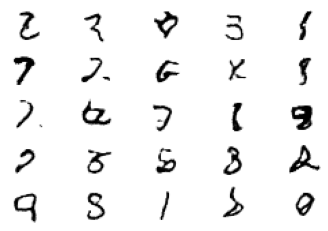

In [28]:
# load model
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)